# Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Try models with just a few data points and force to overfit?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [5]:
loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [ ]:
# get a few selected genes (10 top, 10 bottom in highCu)

In [15]:
XYdf = XYdf_og[['locus_tag','upstream_region','highCu']]
XYdf_smol = pd.concat([XYdf.sort_values('highCu').head(10),XYdf.sort_values('highCu').tail(10)])
XYdf_smol['gene'] = XYdf_smol['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_smol['product'] = XYdf_smol['locus_tag'].apply(lambda x: locus2info[x]['product'])


XYdf_smol

,locus_tag,upstream_region,highCu,gene,product
589,EQU24_RS05885,ATTCATGTCCTGCCCTCATTTTGAAACGGTGGCGTGTTGTCGAGTG...,-8.844506,mmoX,methane monooxygenase
590,EQU24_RS05905,GCTGAGGTTTTTTAAGCCATGCGCGTTCTGTTATCCGGTCTGCTTA...,-7.574592,mmoD,soluble methane monooxygenase-binding protein ...
592,EQU24_RS05920,GGTTTTAATAAAATCGACAATGAAACATTGGATTGTATGGACGGCT...,-7.357154,NaN,hypothetical protein
591,EQU24_RS05915,TACACTGGTTACCGGCAATCCCTGCCGGTATGACGGGTCTTTTGGC...,-7.275122,NaN,BLUF domain-containing protein
593,EQU24_RS05925,CATTTTTACATGGTCTCGATTGAATCGAGTCCATGAAACCAGAGCA...,-7.104795,mmoG,likely chaperone for smmo
2082,EQU24_RS21000,TGCTAGCCATTTGAGGGGCGTCACGGCGCCGAAATCGGGTTAGCAA...,-5.746211,NaN,hypothetical protein
2083,EQU24_RS21005,AAGATCTGTTCGTCGAACCCGATGCGGAAGTGCAGGATTTCAAGAC...,-5.424244,NaN,hypothetical protein
1926,EQU24_RS19520,CACACAGTTTAGGTGTGTGATATCACGCAGTCCCATACTTCATTTT...,-5.383131,NaN,type II secretion system protein
60,EQU24_RS00670,ATTCCGATGGGTATGTAACCAAATCTTTAGTAGCTGAACGCGACTG...,-5.215366,NaN,hypothetical protein
587,EQU24_RS05870,CGTTCGAACTGCCGTCAAGACCCCCAGGAGAGGATGGGATCATGGC...,-4.124782,NaN,hypothetical protein


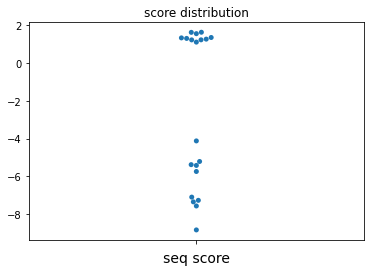

In [62]:
sns.swarmplot(y=XYdf_smol['highCu'].values,orient="v")
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.show()

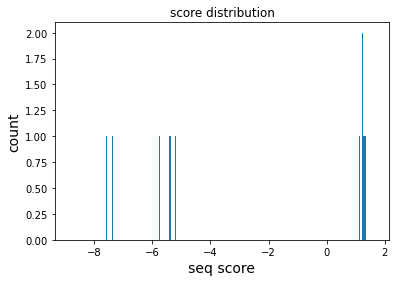

In [16]:
plt.hist(XYdf_smol['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

In [17]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"LR TPM Distribution")
    plt.show()

## Load 5G seqs into data loaders

In [18]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [19]:

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    XYdf_smol, 
    XYdf_smol, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [20]:
len(kmer6_train_dl.dataset.kmers)

4096

## Optuna objective functions
study.optimize seems to only take trial as an input and automatically. In order to pass epochs and train/test data loaders, I think I have to wrap it in an extra Model class? Then calls the Model's self.objective?

In [21]:
class OptWrap:
    '''
    Adapted from: 
    https://github.com/FernandoLpz/Optuna-Sklearn-PyTorch/blob/master/optuna_pytorch.py
    
    Optuna needs to call "study.optimize" on a function with no inputs other 
    than trial... trying to make that happen here...
    '''
    
    def __init__(self, 
                 name, 
                 model_class, 
                 seq_len, 
                 epochs, 
                 loss_func, 
                 learning_rate,
                 train_loader, 
                 test_loader
                ):
        self.name = name
        self.model_class = model_class
        self.seq_len = seq_len
        self.epochs = epochs
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_loss_list = []
        self.test_loss_list = []
        self.trial_count = 0
        self.best_train_loss = None
        self.best_test_loss = None
        self.best_model = None
        
    def optimize(self, trial):
        self.trial_count += 1 # increments with trials run for this model
        # Initialize model with the current trial
        model = self.model_class(trial, self.seq_len).to(DEVICE)
        train_losses = []
        test_losses = []
        # ^^ collect per trial
        
        # Define space search for training settings
        #learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        
        # in the future, consider optimizer as a hyperparameter
        #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        #opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        opt = torch.optim.SGD(model.parameters(), lr=self.learning_rate) 
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = tu.train_step(model, self.train_loader, loss_func, DEVICE, opt)
            
            test_loss = tu.test_step(model, self.test_loader, loss_func, DEVICE)
            print(f"E{epoch}: {test_loss}")
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            # decide if trial should be pruned
            trial.report(test_loss, epoch)
            if trial.should_prune():
                # add partial trials to the train history
                self.train_loss_list.append(train_losses)
                self.test_loss_list.append(test_losses)
                
                raise optuna.exceptions.TrialPruned()
                
        
        # return history of this trials training/test loss?
        self.train_loss_list.append(train_losses)
        self.test_loss_list.append(test_losses)
        
        # return final test loss?? or best test loss?? 
        # TODO/QUESTION: try best test loss instead of final
        # CALLBACKS?
        
        print("****Model Arch ****")
        print(model)
        print("*******************")
        
        return test_loss
    
    def retrain_best(self, trial):
        '''
        Use a Frozen trial to retrain/return a model with the 
        best hyperparameters
        '''
        assert(type(trial) == optuna.trial.FrozenTrial)
        
        model = self.model_class(trial, self.seq_len).to(DEVICE)
        train_losses = []
        test_losses = []
        
        # These aren't suggestions anymore - they are chosen from the 
        # specs of the Frozen Trial
        #learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        
        # in the future, consider optimizer as a hyperparameter
        #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        #opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        opt = torch.optim.SGD(model.parameters(), lr=self.learning_rate) 

        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = tu.train_step(model, self.train_loader, loss_func, DEVICE, opt)
            
            test_loss = tu.test_step(model, self.test_loader, loss_func, DEVICE)
            print(f"E{epoch}: {test_loss}")
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        # Update history for current best
        if self.best_model is not None:
            print("Warning: overwriting best model with new best model")
        self.best_train_loss = train_losses
        self.best_test_loss = test_losses
        self.best_model = model
        
        return model
            
        
        



In [22]:
def print_study(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value : ", trial.value)
    print("  Number: ", trial.number)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

## try defining flexible model class with Optuna

In [23]:
# defining a deep linear model with Optuna
class DNA_Linear_Opt(nn.ModuleList):
    def __init__(self, trial, seq_len):
        super().__init__()
        
        self.seq_len = seq_len
        # Where the layers and dropouts will be stacked
        layers = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("linear layer num:", n_hidden_fc)
        
        # input sequence size
        input_dim = 4*seq_len
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        prev_linear_node_num = input_dim
        for i in range(1,n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64,128])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            #output_dim = trial.suggest_int(f"output_dim_{layer}", 1, 100)#, log=True)
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
        
        # concat all the layers together
        self.lin = nn.Sequential(*layers)
            
    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

## Optuna: Linear model

In [25]:
seq_len = len(XYdf_smol['upstream_region'].values[0])
print("seq len", seq_len)
eps=20
loss_func = torch.nn.MSELoss()
lr= 0.0001

lin_ow = OptWrap(
    "DNA_Linear_Opt",
    DNA_Linear_Opt,
    seq_len,
    eps,
    loss_func,
    lr,
    ohe_train_dl, 
    ohe_val_dl
)

lin_opt_study = optuna.create_study(direction="minimize")

lin_opt_study.optimize(lin_ow.optimize, n_trials=200)
print()
print_study(lin_opt_study)

[I 2021-10-01 17:12:03,258] A new study created in memory with name: no-name-413c6e6d-a748-4e48-ba93-54c399ed1d50


seq len 300
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3


[I 2021-10-01 17:12:13,925] Trial 0 finished with value: 20.579328536987305 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.3}. Best is trial 0 with value: 20.579328536987305.
[I 2021-10-01 17:12:13,960] Trial 1 finished with value: 18.052188873291016 and parameters: {'n_hidden_fc': 0}. Best is trial 1 with value: 18.052188873291016.
[I 2021-10-01 17:12:14,013] Trial 2 finished with value: 20.92127799987793 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 128, 'lin1_dropout': 0.2}. Best is trial 1 with value: 18.052188873291016.
[I 2021-10-01 17:12:14,048] Trial 3 finished with value: 17.838050842285156 and parameters: {'n_hidden_fc': 0}. Best is trial 3 with value: 17.838050842285156.
[I 2021-10-01 17:12:14,084] Trial 4 finished with value: 18.008371353149414 and parameters: {'n_hidden_fc': 0}. Best is trial 3 with value: 17.838050842285156.


E0: 21.3253231048584
E1: 21.281978607177734
E2: 21.24274444580078
E3: 21.2052059173584
E4: 21.166568756103516
E5: 21.126005172729492
E6: 21.08580207824707
E7: 21.0472469329834
E8: 21.006244659423828
E9: 20.96767807006836
E10: 20.92711639404297
E11: 20.88751792907715
E12: 20.853378295898438
E13: 20.810989379882812
E14: 20.775924682617188
E15: 20.73508644104004
E16: 20.6953182220459
E17: 20.656230926513672
E18: 20.620576858520508
E19: 20.579328536987305
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.48603630065918
E1: 22.19121742248535
E2: 21.904632568359375
E3: 21.626001358032227
E4: 21.35504150390625
E5: 21.091495513916016
E6: 20.835102081298828
E7: 20.585617065429688
E8: 20.342809677124023
E9: 20.10643768310547
E10: 19.876291275024414
E11

[I 2021-10-01 17:12:14,092] Trial 5 pruned. 
[I 2021-10-01 17:12:14,132] Trial 6 finished with value: 17.199481964111328 and parameters: {'n_hidden_fc': 0}. Best is trial 6 with value: 17.199481964111328.
[I 2021-10-01 17:12:14,139] Trial 7 pruned. 
[I 2021-10-01 17:12:14,142] Trial 8 pruned. 
[I 2021-10-01 17:12:14,146] Trial 9 pruned. 
[I 2021-10-01 17:12:14,157] Trial 10 pruned. 
[I 2021-10-01 17:12:14,200] Trial 11 finished with value: 16.973556518554688 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,244] Trial 12 finished with value: 17.051864624023438 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,257] Trial 13 pruned. 
[I 2021-10-01 17:12:14,264] Trial 14 pruned. 
[I 2021-10-01 17:12:14,284] Trial 15 pruned. 


 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 128
lin2_dropout 0.2
E0: 22.453935623168945
linear layer num: 0
E0: 21.459829330444336
E1: 21.176244735717773
E2: 20.90061378479004
E3: 20.63266372680664
E4: 20.37212562561035
E5: 20.118745803833008
E6: 19.872278213500977
E7: 19.63248062133789
E8: 19.39912986755371
E9: 19.1719970703125
E10: 18.95087432861328
E11: 18.73555564880371
E12: 18.525836944580078
E13: 18.321531295776367
E14: 18.12245750427246
E15: 17.928428649902344
E16: 17.739282608032227
E17: 17.554847717285156
E18: 17.374963760375977
E19: 17.199481964111328
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0
E0: 21.963939666748047
E1: 21.9267520904541
linear layer num: 0
E0: 24.502689361572266
linear layer num: 0
E0: 22.379985809326172
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.2
lin2_fc_nodes 32
lin2_dropout 0.1
E0: 22.26001

[I 2021-10-01 17:12:14,292] Trial 16 pruned. 
[I 2021-10-01 17:12:14,303] Trial 17 pruned. 
[I 2021-10-01 17:12:14,346] Trial 18 finished with value: 17.18682289123535 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 16.973556518554688.
[I 2021-10-01 17:12:14,354] Trial 19 pruned. 
[I 2021-10-01 17:12:14,361] Trial 20 pruned. 
[I 2021-10-01 17:12:14,367] Trial 21 pruned. 
[I 2021-10-01 17:12:14,411] Trial 22 finished with value: 16.944931030273438 and parameters: {'n_hidden_fc': 0}. Best is trial 22 with value: 16.944931030273438.
[I 2021-10-01 17:12:14,418] Trial 23 pruned. 
[I 2021-10-01 17:12:14,429] Trial 24 pruned. 
[I 2021-10-01 17:12:14,436] Trial 25 pruned. 
[I 2021-10-01 17:12:14,443] Trial 26 pruned. 
[I 2021-10-01 17:12:14,449] Trial 27 pruned. 
[I 2021-10-01 17:12:14,459] Trial 28 pruned. 
[I 2021-10-01 17:12:14,469] Trial 29 pruned. 
[I 2021-10-01 17:12:14,476] Trial 30 pruned. 


E0: 22.119266510009766
linear layer num: 2
lin1_fc_nodes 128
lin1_dropout 0.1
lin2_fc_nodes 16
lin2_dropout 0
E0: 22.760150909423828
linear layer num: 0
E0: 21.225130081176758
E1: 20.95793342590332
E2: 20.698055267333984
E3: 20.445241928100586
E4: 20.19925308227539
E5: 19.95985221862793
E6: 19.7268123626709
E7: 19.499914169311523
E8: 19.27895164489746
E9: 19.063720703125
E10: 18.85402488708496
E11: 18.649673461914062
E12: 18.45048713684082
E13: 18.256290435791016
E14: 18.066913604736328
E15: 17.882192611694336
E16: 17.70197296142578
E17: 17.52610206604004
E18: 17.354433059692383
E19: 17.18682289123535
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.2
E0: 23.40277862548828
linear layer num: 0
E0: 21.579179763793945
linear layer num: 0
E0: 22.633150100708008
linear layer num: 0
E0: 20.830976486206055
E1: 20.574491500854492
E2: 20.3249626159667

[I 2021-10-01 17:12:14,520] Trial 31 finished with value: 17.22092056274414 and parameters: {'n_hidden_fc': 0}. Best is trial 22 with value: 16.944931030273438.
[I 2021-10-01 17:12:14,527] Trial 32 pruned. 
[I 2021-10-01 17:12:14,534] Trial 33 pruned. 
[I 2021-10-01 17:12:14,541] Trial 34 pruned. 
[I 2021-10-01 17:12:14,547] Trial 35 pruned. 
[I 2021-10-01 17:12:14,554] Trial 36 pruned. 
[I 2021-10-01 17:12:14,560] Trial 37 pruned. 
[I 2021-10-01 17:12:14,566] Trial 38 pruned. 
[I 2021-10-01 17:12:14,575] Trial 39 pruned. 
[I 2021-10-01 17:12:14,618] Trial 40 finished with value: 16.901315689086914 and parameters: {'n_hidden_fc': 0}. Best is trial 40 with value: 16.901315689086914.
[I 2021-10-01 17:12:14,625] Trial 41 pruned. 
[I 2021-10-01 17:12:14,668] Trial 42 finished with value: 16.400487899780273 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,675] Trial 43 pruned. 
[I 2021-10-01 17:12:14,681] Trial 44 pruned. 
[I 2021-1

E6: 19.8253231048584
E7: 19.592151641845703
E8: 19.36516571044922
E9: 19.144149780273438
E10: 18.928905487060547
E11: 18.719228744506836
E12: 18.51493263244629
E13: 18.315834045410156
E14: 18.121755599975586
E15: 17.93252944946289
E16: 17.747989654541016
E17: 17.567975997924805
E18: 17.392332077026367
E19: 17.22092056274414
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.656347274780273
linear layer num: 0
E0: 21.846017837524414
linear layer num: 0
E0: 24.2701473236084
linear layer num: 0
E0: 22.316186904907227
linear layer num: 0
E0: 23.30950927734375
linear layer num: 0
E0: 22.13075065612793
linear layer num: 0
E0: 21.49183464050293
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 22.89377212524414
linear layer num: 0
E0: 20.661911010742188
E1: 20.41460609436035
E2: 20.173908233642578
E3: 19.939586639404297
E4: 19.711429595947266
E5: 19.48921775817871
E6: 

[I 2021-10-01 17:12:14,699] Trial 46 pruned. 
[I 2021-10-01 17:12:14,705] Trial 47 pruned. 
[I 2021-10-01 17:12:14,711] Trial 48 pruned. 
[I 2021-10-01 17:12:14,720] Trial 49 pruned. 
[I 2021-10-01 17:12:14,727] Trial 50 pruned. 
[I 2021-10-01 17:12:14,734] Trial 51 pruned. 
[I 2021-10-01 17:12:14,741] Trial 52 pruned. 
[I 2021-10-01 17:12:14,747] Trial 53 pruned. 
[I 2021-10-01 17:12:14,754] Trial 54 pruned. 
[I 2021-10-01 17:12:14,760] Trial 55 pruned. 
[I 2021-10-01 17:12:14,767] Trial 56 pruned. 
[I 2021-10-01 17:12:14,775] Trial 57 pruned. 
[I 2021-10-01 17:12:14,781] Trial 58 pruned. 
[I 2021-10-01 17:12:14,825] Trial 59 finished with value: 16.61433219909668 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,836] Trial 60 pruned. 
[I 2021-10-01 17:12:14,843] Trial 61 pruned. 
[I 2021-10-01 17:12:14,850] Trial 62 pruned. 
[I 2021-10-01 17:12:14,894] Trial 63 finished with value: 17.066743850708008 and parameters: {'n_hidden

lin2_fc_nodes 8
lin2_dropout 0.3
E0: 22.601821899414062
linear layer num: 0
E0: 23.46243667602539
linear layer num: 0
E0: 21.96183204650879
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.2
E0: 22.302473068237305
linear layer num: 0
E0: 21.460111618041992
linear layer num: 0
E0: 22.606874465942383
linear layer num: 0
E0: 22.91286277770996
linear layer num: 0
E0: 22.430156707763672
linear layer num: 0
E0: 22.491710662841797
linear layer num: 0
E0: 22.844627380371094
linear layer num: 0
E0: 23.82143211364746
linear layer num: 0
E0: 22.560216903686523
linear layer num: 0
E0: 22.260578155517578
linear layer num: 0
E0: 20.62742805480957
E1: 20.361143112182617
E2: 20.102235794067383
E3: 19.850448608398438
E4: 19.605539321899414
E5: 19.367267608642578
E6: 19.135408401489258
E7: 18.909738540649414
E8: 18.690046310424805
E9: 18.47612953186035
E10: 18.267789840698242
E11: 18.064830780029297
E12: 17.867074966430664
E13: 17.674346923828125
E14: 17.48647117614746
E15: 17.303281784057617
E16: 17

[I 2021-10-01 17:12:14,938] Trial 64 finished with value: 16.911874771118164 and parameters: {'n_hidden_fc': 0}. Best is trial 42 with value: 16.400487899780273.
[I 2021-10-01 17:12:14,945] Trial 65 pruned. 
[I 2021-10-01 17:12:14,952] Trial 66 pruned. 
[I 2021-10-01 17:12:14,959] Trial 67 pruned. 
[I 2021-10-01 17:12:15,004] Trial 68 finished with value: 16.336854934692383 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,010] Trial 69 pruned. 
[I 2021-10-01 17:12:15,017] Trial 70 pruned. 
[I 2021-10-01 17:12:15,024] Trial 71 pruned. 
[I 2021-10-01 17:12:15,030] Trial 72 pruned. 
[I 2021-10-01 17:12:15,037] Trial 73 pruned. 
[I 2021-10-01 17:12:15,044] Trial 74 pruned. 
[I 2021-10-01 17:12:15,051] Trial 75 pruned. 
[I 2021-10-01 17:12:15,058] Trial 76 pruned. 
[I 2021-10-01 17:12:15,064] Trial 77 pruned. 
[I 2021-10-01 17:12:15,071] Trial 78 pruned. 
[I 2021-10-01 17:12:15,080] Trial 79 pruned. 
[I 2021-10-01 17:12:15,087] Tria

linear layer num: 0
E0: 20.864362716674805
E1: 20.603025436401367
E2: 20.34882164001465
E3: 20.101512908935547
E4: 19.86086082458496
E5: 19.626630783081055
E6: 19.398609161376953
E7: 19.176576614379883
E8: 18.96033477783203
E9: 18.749685287475586
E10: 18.54443359375
E11: 18.344396591186523
E12: 18.14940071105957
E13: 17.959270477294922
E14: 17.773841857910156
E15: 17.592958450317383
E16: 17.41646385192871
E17: 17.24421501159668
E18: 17.07606315612793
E19: 16.911874771118164
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.29059410095215
linear layer num: 0
E0: 23.223310470581055
linear layer num: 0
E0: 22.26308250427246
linear layer num: 0
E0: 19.895856857299805
E1: 19.66219711303711
E2: 19.434738159179688
E3: 19.2132625579834
E4: 18.997570037841797
E5: 18.78746223449707
E6: 18.582744598388672
E7: 18.383237838745117
E8: 18.188762664794922
E9: 17.9991455078125
E10: 1

[I 2021-10-01 17:12:15,139] Trial 82 finished with value: 16.864408493041992 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,146] Trial 83 pruned. 
[I 2021-10-01 17:12:15,152] Trial 84 pruned. 
[I 2021-10-01 17:12:15,159] Trial 85 pruned. 
[I 2021-10-01 17:12:15,165] Trial 86 pruned. 
[I 2021-10-01 17:12:15,209] Trial 87 finished with value: 16.575071334838867 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,216] Trial 88 pruned. 
[I 2021-10-01 17:12:15,223] Trial 89 pruned. 
[I 2021-10-01 17:12:15,229] Trial 90 pruned. 
[I 2021-10-01 17:12:15,236] Trial 91 pruned. 
[I 2021-10-01 17:12:15,280] Trial 92 finished with value: 16.61121368408203 and parameters: {'n_hidden_fc': 0}. Best is trial 68 with value: 16.336854934692383.
[I 2021-10-01 17:12:15,287] Trial 93 pruned. 


E0: 21.040647506713867
E1: 20.762725830078125
E2: 20.492591857910156
E3: 20.229978561401367
E4: 19.97462272644043
E5: 19.72627830505371
E6: 19.484697341918945
E7: 19.249652862548828
E8: 19.020915985107422
E9: 18.798269271850586
E10: 18.581510543823242
E11: 18.37042808532715
E12: 18.16483497619629
E13: 17.96454429626465
E14: 17.76936912536621
E15: 17.579143524169922
E16: 17.39369010925293
E17: 17.21285629272461
E18: 17.036476135253906
E19: 16.864408493041992
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.348865509033203
linear layer num: 0
E0: 23.381736755371094
linear layer num: 0
E0: 24.045454025268555
linear layer num: 0
E0: 22.518630981445312
linear layer num: 0
E0: 20.25741195678711
E1: 20.015174865722656
E2: 19.779417037963867
E3: 19.549915313720703
E4: 19.32645606994629
E5: 19.10883140563965
E6: 18.896846771240234
E7: 18.690303802490234
E8: 18.4890193939209


[I 2021-10-01 17:12:15,332] Trial 94 finished with value: 16.284191131591797 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,376] Trial 95 finished with value: 16.77741241455078 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,383] Trial 96 pruned. 
[I 2021-10-01 17:12:15,389] Trial 97 pruned. 
[I 2021-10-01 17:12:15,398] Trial 98 pruned. 
[I 2021-10-01 17:12:15,405] Trial 99 pruned. 
[I 2021-10-01 17:12:15,412] Trial 100 pruned. 
[I 2021-10-01 17:12:15,418] Trial 101 pruned. 
[I 2021-10-01 17:12:15,425] Trial 102 pruned. 
[I 2021-10-01 17:12:15,431] Trial 103 pruned. 
[I 2021-10-01 17:12:15,438] Trial 104 pruned. 
[I 2021-10-01 17:12:15,445] Trial 105 pruned. 
[I 2021-10-01 17:12:15,451] Trial 106 pruned. 
[I 2021-10-01 17:12:15,458] Trial 107 pruned. 
[I 2021-10-01 17:12:15,465] Trial 108 pruned. 
[I 2021-10-01 17:12:15,471] Trial 109 pruned. 
[I 2021-10-01 17:12:15,

E5: 18.659912109375
E6: 18.46217155456543
E7: 18.26935386657715
E8: 18.081287384033203
E9: 17.89781379699707
E10: 17.718780517578125
E11: 17.54403305053711
E12: 17.373430252075195
E13: 17.20683479309082
E14: 17.044109344482422
E15: 16.88512420654297
E16: 16.729759216308594
E17: 16.577892303466797
E18: 16.429407119750977
E19: 16.284191131591797
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.703161239624023
E1: 20.4434757232666
E2: 20.190893173217773
E3: 19.945173263549805
E4: 19.706079483032227
E5: 19.473379135131836
E6: 19.246858596801758
E7: 19.026302337646484
E8: 18.811508178710938
E9: 18.602277755737305
E10: 18.398422241210938
E11: 18.199758529663086
E12: 18.0061092376709
E13: 17.817304611206055
E14: 17.6331787109375
E15: 17.453577041625977
E16: 17.278343200683594
E17: 17.10733413696289
E18: 16.940399169921875
E19: 16.77741241455078
****Model Arch ****
DNA_Line

[I 2021-10-01 17:12:15,536] Trial 113 finished with value: 16.831602096557617 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,543] Trial 114 pruned. 
[I 2021-10-01 17:12:15,550] Trial 115 pruned. 
[I 2021-10-01 17:12:15,556] Trial 116 pruned. 
[I 2021-10-01 17:12:15,563] Trial 117 pruned. 
[I 2021-10-01 17:12:15,575] Trial 118 pruned. 
[I 2021-10-01 17:12:15,581] Trial 119 pruned. 
[I 2021-10-01 17:12:15,588] Trial 120 pruned. 
[I 2021-10-01 17:12:15,595] Trial 121 pruned. 
[I 2021-10-01 17:12:15,602] Trial 122 pruned. 
[I 2021-10-01 17:12:15,608] Trial 123 pruned. 
[I 2021-10-01 17:12:15,615] Trial 124 pruned. 
[I 2021-10-01 17:12:15,622] Trial 125 pruned. 
[I 2021-10-01 17:12:15,629] Trial 126 pruned. 
[I 2021-10-01 17:12:15,635] Trial 127 pruned. 
[I 2021-10-01 17:12:15,642] Trial 128 pruned. 
[I 2021-10-01 17:12:15,649] Trial 129 pruned. 
[I 2021-10-01 17:12:15,656] Trial 130 pruned. 
[I 2021-10-01 17:12:15,663] Trial 131 

E4: 19.626068115234375
E5: 19.405141830444336
E6: 19.189922332763672
E7: 18.98021697998047
E8: 18.775833129882812
E9: 18.576595306396484
E10: 18.382322311401367
E11: 18.192853927612305
E12: 18.008024215698242
E13: 17.827672958374023
E14: 17.651653289794922
E15: 17.47981834411621
E16: 17.312030792236328
E17: 17.148149490356445
E18: 16.98805046081543
E19: 16.831602096557617
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 22.794782638549805
linear layer num: 0
E0: 21.79790687561035
linear layer num: 0
E0: 21.305715560913086
linear layer num: 0
E0: 23.147260665893555
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.3
lin2_fc_nodes 8
lin2_dropout 0.1
E0: 23.94002342224121
linear layer num: 0
E0: 21.571247100830078
linear layer num: 0
E0: 22.255475997924805
linear layer num: 0
E0: 23.643404006958008
linear layer num: 0
E0: 21.541790008544922
linear layer num: 0
E0: 22.324

[I 2021-10-01 17:12:15,715] Trial 133 finished with value: 16.82603645324707 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,722] Trial 134 pruned. 
[I 2021-10-01 17:12:15,729] Trial 135 pruned. 
[I 2021-10-01 17:12:15,771] Trial 136 pruned. 
[I 2021-10-01 17:12:15,778] Trial 137 pruned. 
[I 2021-10-01 17:12:15,785] Trial 138 pruned. 
[I 2021-10-01 17:12:15,829] Trial 139 finished with value: 16.627817153930664 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,874] Trial 140 finished with value: 16.662626266479492 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:15,881] Trial 141 pruned. 
[I 2021-10-01 17:12:15,888] Trial 142 pruned. 
[I 2021-10-01 17:12:15,895] Trial 143 pruned. 
[I 2021-10-01 17:12:15,902] Trial 144 pruned. 
[I 2021-10-01 17:12:15,909] Trial 145 pruned. 


E16: 17.290014266967773
E17: 17.1318416595459
E18: 16.977224349975586
E19: 16.82603645324707
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 23.670013427734375
linear layer num: 0
E0: 22.366487503051758
linear layer num: 0
E0: 20.73543930053711
E1: 20.485342025756836
E2: 20.241954803466797
E3: 20.005041122436523
E4: 19.774383544921875
E5: 19.54976463317871
E6: 19.330982208251953
E7: 19.117830276489258
E8: 18.910123825073242
E9: 18.707672119140625
E10: 18.510297775268555
E11: 18.317832946777344
E12: 18.130107879638672
E13: 17.94696044921875
E14: 17.76824378967285
E15: 17.593801498413086
E16: 17.423490524291992
E17: 17.257177352905273
E18: 17.0947208404541
linear layer num: 0
E0: 21.04501724243164
linear layer num: 0
E0: 24.11170768737793
linear layer num: 0
E0: 19.970155715942383
E1: 19.75308609008789
E2: 19.5415096282959
E3: 19.335241317749023
E4: 19.134105682373047
E

[I 2021-10-01 17:12:15,916] Trial 146 pruned. 
[I 2021-10-01 17:12:15,923] Trial 147 pruned. 
[I 2021-10-01 17:12:15,930] Trial 148 pruned. 
[I 2021-10-01 17:12:15,937] Trial 149 pruned. 
[I 2021-10-01 17:12:15,944] Trial 150 pruned. 
[I 2021-10-01 17:12:15,951] Trial 151 pruned. 
[I 2021-10-01 17:12:15,957] Trial 152 pruned. 
[I 2021-10-01 17:12:15,964] Trial 153 pruned. 
[I 2021-10-01 17:12:15,971] Trial 154 pruned. 
[I 2021-10-01 17:12:15,978] Trial 155 pruned. 
[I 2021-10-01 17:12:15,985] Trial 156 pruned. 
[I 2021-10-01 17:12:15,992] Trial 157 pruned. 
[I 2021-10-01 17:12:15,999] Trial 158 pruned. 
[I 2021-10-01 17:12:16,045] Trial 159 finished with value: 16.658498764038086 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:16,058] Trial 160 pruned. 
[I 2021-10-01 17:12:16,065] Trial 161 pruned. 
[I 2021-10-01 17:12:16,072] Trial 162 pruned. 
[I 2021-10-01 17:12:16,079] Trial 163 pruned. 
[I 2021-10-01 17:12:16,087] Trial 164 

linear layer num: 0
E0: 21.937707901000977
linear layer num: 0
E0: 21.932348251342773
linear layer num: 0
E0: 21.204126358032227
linear layer num: 0
E0: 21.90351104736328
linear layer num: 0
E0: 22.34740447998047
linear layer num: 0
E0: 22.9040584564209
linear layer num: 0
E0: 20.920021057128906
linear layer num: 0
E0: 22.601150512695312
linear layer num: 0
E0: 22.978992462158203
linear layer num: 0
E0: 22.306243896484375
linear layer num: 0
E0: 22.925243377685547
linear layer num: 0
E0: 22.818204879760742
linear layer num: 0
E0: 23.124378204345703
linear layer num: 0
E0: 20.613140106201172
E1: 20.351255416870117
E2: 20.096569061279297
E3: 19.848827362060547
E4: 19.60780143737793
E5: 19.37325096130371
E6: 19.144956588745117
E7: 18.922704696655273
E8: 18.706287384033203
E9: 18.49550437927246
E10: 18.290164947509766
E11: 18.090084075927734
E12: 17.895078659057617
E13: 17.704980850219727
E14: 17.519620895385742
E15: 17.338842391967773
E16: 17.162485122680664
E17: 16.990406036376953
E18: 1

[I 2021-10-01 17:12:16,154] Trial 168 finished with value: 16.602991104125977 and parameters: {'n_hidden_fc': 0}. Best is trial 94 with value: 16.284191131591797.
[I 2021-10-01 17:12:16,161] Trial 169 pruned. 
[I 2021-10-01 17:12:16,168] Trial 170 pruned. 
[I 2021-10-01 17:12:16,175] Trial 171 pruned. 
[I 2021-10-01 17:12:16,182] Trial 172 pruned. 
[I 2021-10-01 17:12:16,189] Trial 173 pruned. 
[I 2021-10-01 17:12:16,196] Trial 174 pruned. 
[I 2021-10-01 17:12:16,203] Trial 175 pruned. 
[I 2021-10-01 17:12:16,210] Trial 176 pruned. 
[I 2021-10-01 17:12:16,217] Trial 177 pruned. 
[I 2021-10-01 17:12:16,224] Trial 178 pruned. 
[I 2021-10-01 17:12:16,231] Trial 179 pruned. 
[I 2021-10-01 17:12:16,238] Trial 180 pruned. 
[I 2021-10-01 17:12:16,245] Trial 181 pruned. 
[I 2021-10-01 17:12:16,252] Trial 182 pruned. 
[I 2021-10-01 17:12:16,259] Trial 183 pruned. 
[I 2021-10-01 17:12:16,267] Trial 184 pruned. 
[I 2021-10-01 17:12:16,274] Trial 185 pruned. 
[I 2021-10-01 17:12:16,281] Trial 186 

E0: 19.955495834350586
E1: 19.73773765563965
E2: 19.525497436523438
E3: 19.318584442138672
E4: 19.116817474365234
E5: 18.920024871826172
E6: 18.7280330657959
E7: 18.540685653686523
E8: 18.357826232910156
E9: 18.179304122924805
E10: 18.004966735839844
E11: 17.834686279296875
E12: 17.668317794799805
E13: 17.505735397338867
E14: 17.346813201904297
E15: 17.19142723083496
E16: 17.03946304321289
E17: 16.890806198120117
E18: 16.745351791381836
E19: 16.602991104125977
****Model Arch ****
DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.30446434020996
linear layer num: 0
E0: 22.061037063598633
linear layer num: 0
E0: 21.096572875976562
linear layer num: 0
E0: 21.76078224182129
linear layer num: 0
E0: 22.204252243041992
linear layer num: 0
E0: 22.9775447845459
linear layer num: 0
E0: 21.978548049926758
linear layer num: 0
E0: 22.17575454711914
linear layer num: 0
E0: 22.593732833862305
linear la

[I 2021-10-01 17:12:16,320] Trial 190 pruned. 
[I 2021-10-01 17:12:16,328] Trial 191 pruned. 
[I 2021-10-01 17:12:16,335] Trial 192 pruned. 
[I 2021-10-01 17:12:16,342] Trial 193 pruned. 
[I 2021-10-01 17:12:16,349] Trial 194 pruned. 
[I 2021-10-01 17:12:16,356] Trial 195 pruned. 
[I 2021-10-01 17:12:16,364] Trial 196 pruned. 
[I 2021-10-01 17:12:16,371] Trial 197 pruned. 
[I 2021-10-01 17:12:16,378] Trial 198 pruned. 
[I 2021-10-01 17:12:16,385] Trial 199 pruned. 


E2: 20.20271110534668
E3: 20.154727935791016
linear layer num: 0
E0: 21.38842010498047
linear layer num: 0
E0: 21.71734619140625
linear layer num: 0
E0: 23.093353271484375
linear layer num: 0
E0: 21.32118797302246
linear layer num: 0
E0: 22.34456443786621
linear layer num: 0
E0: 21.908945083618164
linear layer num: 0
E0: 22.22910499572754
linear layer num: 0
E0: 22.274913787841797
linear layer num: 0
E0: 22.24946403503418

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  172
  Number of complete trials:  28
Best trial:
  Value :  16.284191131591797
  Number:  94
  Params: 
    n_hidden_fc: 0


In [26]:
print_study(lin_opt_study)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  172
  Number of complete trials:  28
Best trial:
  Value :  16.284191131591797
  Number:  94
  Params: 
    n_hidden_fc: 0


In [27]:
best_lin = lin_ow.retrain_best(lin_opt_study.best_trial)


linear layer num: 0
E0: 22.93743324279785
E1: 22.60401725769043
E2: 22.280311584472656
E3: 21.96598243713379
E4: 21.66070556640625
E5: 21.36415672302246
E6: 21.0760440826416
E7: 20.796066284179688
E8: 20.523944854736328
E9: 20.25941276550293
E10: 20.002197265625
E11: 19.75205421447754
E12: 19.508737564086914
E13: 19.272008895874023
E14: 19.041645050048828
E15: 18.817426681518555
E16: 18.59914207458496
E17: 18.38658905029297
E18: 18.1795711517334
E19: 17.9778995513916


In [28]:
best_lin

DNA_Linear_Opt(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=1, bias=True)
  )
)

In [29]:
oracle_nocu = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu']].values])
oracle_nocu['EQU24_RS19315']

[0.9095671757666924]

In [30]:
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,y='pred',x='truth',hue='task',alpha=0.2)
    #draw y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    
    plt.show()
    
def parity_pred_multi(models, genes, oracle,task,objs,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]
#             print(f"{gene}:{dna}")
#             print(preds)
            
            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],objs[i]))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task'])
        pearson = df['truth'].corr(df['pred'])
        df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
        df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
        df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs

Running LinearDeep_LR:NoCu


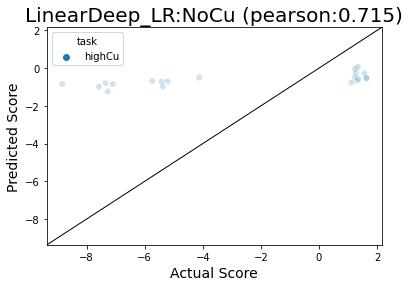

In [33]:
models = [
    ("LinearDeep_LR:NoCu",best_lin,DatasetSpec('ohe')),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = XYdf_smol['locus_tag'].values
task = "opt_best_LR:NoCu"

dfs = parity_pred_multi(models, genes, oracle_nocu,task,['highCu'],alt=False)

In [34]:
pmoc = 'EQU24_RS19315'
pmoc_seq = loc2seq[pmoc]
pmoc_seq_ohe = torch.tensor(u.one_hot_encode(pmoc_seq)).unsqueeze(0).to(DEVICE).float()

print("pmoC pred:",best_lin(pmoc_seq_ohe).item())
print("pmoC actu:", oracle_nocu[pmoc][0])

pmoC pred: -0.7476934194564819
pmoC actu: 0.9095671757666924


## Optuna: CNN Trial

In [35]:
class DNA_CNN_Opt(nn.Module):
    def __init__(self,
                 trial,
                 seq_len,
                ):
        super().__init__()
        self.seq_len = seq_len
        layers = []
        
        # +---------------------+
        # | First Conv Layer (0)|
        # +---------------------+
        conv0_filt_num = trial.suggest_categorical('conv0_filt_num', [16,32,64])
        conv0_kernel_size = trial.suggest_int('conv0_kernel_size',6,24)
        conv0_pool_size = trial.suggest_int('conv0_pool_size',1,3)
        conv0_dropout = trial.suggest_categorical('conv0_dropout',[0,0.1,0.2,0.3])
        
        print("conv0_filt_num", conv0_filt_num)
        print("conv0_kernel_size", conv0_kernel_size)
        print("conv0_pool_size", conv0_pool_size)
        
        linear_node_num = int(np.floor((seq_len - conv0_kernel_size + 1)/conv0_pool_size))
        print("current linear_node_num:",linear_node_num )
        
        layers.append(nn.Conv2d(1, conv0_filt_num, kernel_size=(4,conv0_kernel_size)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d((1,conv0_pool_size))) # def stride = kernel_size
        layers.append(nn.Dropout(conv0_dropout))

        
        # +-----------------------+
        # | Hidden Conv Layers (N)|
        # +-----------------------+
        n_hidden_conv = trial.suggest_int('n_hidden_conv',0,1)
        print("hidden conv layers:", n_hidden_conv)
        prev_conv_filt_num = conv0_filt_num
        
        # for each hidden convolutional layer
        for i in range(1,n_hidden_conv+1):
            # Trial Suggestions
            convi_filt_num = trial.suggest_categorical(f'conv{i}_filt_num', [16,32,64])
            convi_kernel_size = trial.suggest_int(f'conv{i}_kernel_size',1,6)
            convi_pool_size = trial.suggest_int(f'conv{i}_pool_size',1,3)
            convi_dropout = trial.suggest_categorical(f'conv{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"conv{i}_filt_num", convi_filt_num)
            print(f"conv{i}_kernel_size", convi_kernel_size)
            print(f"conv{i}_pool_size", convi_pool_size)
            print(f"conv{i}_dropout", convi_dropout)
            
            # Layer additions
            layers.append(nn.Conv2d(prev_conv_filt_num, convi_filt_num, kernel_size=(1,convi_kernel_size)))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d((1,convi_pool_size)))
            layers.append(nn.Dropout(convi_dropout))
            
            # value updates
            linear_node_num = int(np.floor((linear_node_num - convi_kernel_size + 1)/convi_pool_size))
            print("current linear_node_num:",linear_node_num )
            prev_conv_filt_num = convi_filt_num
        
        # flatten the conv layers pre FC layer
        layers.append(nn.Flatten())
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("n fc layers:", n_hidden_fc)
        
        prev_linear_node_num = linear_node_num*prev_conv_filt_num
        print("From Conv-to-FC node num:",prev_linear_node_num)
        
        for i in range(1, n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64,128])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
            print("current linear_node_num:",prev_linear_node_num )
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
            
        # concat all the layers together
        self.conv_net = nn.Sequential(*layers)
            


    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [36]:
print("seq len", seq_len)
eps=20
loss_func = torch.nn.MSELoss()
lr = 0.001

cnn_ow = OptWrap(
    "DNA_CNN_Opt",
    DNA_CNN_Opt,
    seq_len,
    eps,
    loss_func,
    lr,
    ohe_train_dl, 
    ohe_val_dl
)

cnn_opt_study = optuna.create_study(direction="minimize")

cnn_opt_study.optimize(cnn_ow.optimize, n_trials=200)

print_study(cnn_opt_study)

[I 2021-10-01 17:15:25,861] A new study created in memory with name: no-name-b8b9e41a-3b2a-4660-93d3-3aaaa24a220c


seq len 300
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 4416
E0: 20.862173080444336
E1: 19.306364059448242
E2: 18.09761619567871
E3: 17.175426483154297
E4: 16.515125274658203
E5: 16.076894760131836
E6: 15.802751541137695
E7: 15.631715774536133
E8: 15.516867637634277
E9: 15.428926467895508
E10: 15.35265827178955
E11: 15.280835151672363
E12: 15.210673332214355
E13: 15.141159057617188
E14: 15.071883201599121
E15: 15.002481460571289
E16: 14.932888984680176
E17: 14.863054275512695
E18: 14.792993545532227


[I 2021-10-01 17:15:26,064] Trial 0 finished with value: 14.722899436950684 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 15, 'conv0_pool_size': 2, 'conv0_dropout': 0, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 6, 'conv1_pool_size': 2, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 0 with value: 14.722899436950684.
[I 2021-10-01 17:15:26,127] Trial 1 finished with value: 14.022455215454102 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 15, 'conv0_pool_size': 3, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 1 with value: 14.022455215454102.
[I 2021-10-01 17:15:26,198] Trial 2 finished with value: 14.294896125793457 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 14, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 1, 'conv1_filt_num': 64, 'conv1_kernel_size': 6, 'conv1_pool_size': 2, 'conv1_dropout': 0, 'n_hidden_fc': 0}. Best is trial 1 with 

E19: 14.722899436950684
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 15), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=4416, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 15
conv0_pool_size 3
current linear_node_num: 95
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 6080
lin1_fc_nodes 64
lin1_dropout 0
current linear_node_num: 64
E0: 20.829833984375
E1: 19.676130294799805
E2: 18.710294723510742
E3: 17.884733200073242
E4: 17.196123123168945
E5: 16.646665573120117
E6: 

[I 2021-10-01 17:15:26,318] Trial 4 finished with value: 16.912073135375977 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 18, 'conv0_pool_size': 3, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 1, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.3}. Best is trial 1 with value: 14.022455215454102.
[I 2021-10-01 17:15:26,328] Trial 5 pruned. 
[I 2021-10-01 17:15:26,339] Trial 6 pruned. 
[I 2021-10-01 17:15:26,353] Trial 7 pruned. 
[I 2021-10-01 17:15:26,362] Trial 8 pruned. 
[I 2021-10-01 17:15:26,371] Trial 9 pruned. 
[I 2021-10-01 17:15:26,394] Trial 10 pruned. 
[I 2021-10-01 17:15:26,434] Trial 11 pruned. 


E0: 22.649551391601562
E1: 22.296310424804688
E2: 21.99876594543457
E3: 21.715423583984375
E4: 21.44417953491211
E5: 21.173057556152344
E6: 20.944997787475586
E7: 20.617971420288086
E8: 20.369140625
E9: 20.087848663330078
E10: 19.77237319946289
E11: 19.45140838623047
E12: 19.135421752929688
E13: 18.773618698120117
E14: 18.496503829956055
E15: 18.18965721130371
E16: 17.877649307250977
E17: 17.517290115356445
E18: 17.244022369384766
E19: 16.912073135375977
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 18), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1504, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
*******************
conv0_

[I 2021-10-01 17:15:26,472] Trial 12 pruned. 
[I 2021-10-01 17:15:26,525] Trial 13 pruned. 
[I 2021-10-01 17:15:26,547] Trial 14 pruned. 
[I 2021-10-01 17:15:26,606] Trial 15 pruned. 
[I 2021-10-01 17:15:26,628] Trial 16 pruned. 
[I 2021-10-01 17:15:26,656] Trial 17 pruned. 


E0: 22.44495391845703
conv0_filt_num 16
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0
current linear_node_num: 287
n fc layers: 0
From Conv-to-FC node num: 9184
E0: 20.30572509765625
E1: 19.053892135620117
E2: 18.095394134521484
E3: 17.3654842376709
E4: 16.813718795776367
E5: 16.399169921875
E6: 16.08890724182129
E7: 15.85234546661377
E8: 15.672134399414062
conv0_filt_num 32
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4672
lin1_fc_nodes 64
lin1_dropout 0.1
current linear_node_num: 64
E0: 21.23415184020996
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 1
conv1_filt_num 64
conv1_kernel_size 6
conv1_pool_size 2
conv1_dropout 0
current linear_node_num: 69
n fc layers: 0
From Conv-to-FC node num: 4416
E0: 19.838499069213867
E1: 18.418

[I 2021-10-01 17:15:26,723] Trial 18 finished with value: 9.079869270324707 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 14, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:26,748] Trial 19 pruned. 
[I 2021-10-01 17:15:26,774] Trial 20 pruned. 
[I 2021-10-01 17:15:26,841] Trial 21 finished with value: 10.356062889099121 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 14, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.


E0: 19.480833053588867
E1: 17.6336612701416
E2: 16.313379287719727
E3: 15.34623908996582
E4: 14.603998184204102
E5: 14.021705627441406
E6: 13.537762641906738
E7: 13.11828327178955
E8: 12.725874900817871
E9: 12.351137161254883
E10: 11.995779991149902
E11: 11.646239280700684
E12: 11.30914306640625
E13: 10.976420402526855
E14: 10.651747703552246
E15: 10.326254844665527
E16: 10.003382682800293
E17: 9.688323020935059
E18: 9.382232666015625
E19: 9.079869270324707
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 14), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4592, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 9
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 1
From Con

[I 2021-10-01 17:15:26,912] Trial 22 finished with value: 9.93834114074707 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:26,981] Trial 23 finished with value: 9.953766822814941 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:27,048] Trial 24 finished with value: 9.221864700317383 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.


E6: 13.708122253417969
E7: 13.378107070922852
E8: 13.068130493164062
E9: 12.757837295532227
E10: 12.465478897094727
E11: 12.172431945800781
E12: 11.888877868652344
E13: 11.60319709777832
E14: 11.323031425476074
E15: 11.037371635437012
E16: 10.753255844116211
E17: 10.482481002807617
E18: 10.205562591552734
E19: 9.93834114074707
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 13), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4608, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 16
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4640
E0: 19.867591857910156
E1: 18.001657485961914
E2: 16.67401885986328
E3: 15.719128608703613
E4: 15.01953792572

[I 2021-10-01 17:15:27,118] Trial 25 finished with value: 9.708258628845215 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:27,185] Trial 26 finished with value: 9.547064781188965 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:27,204] Trial 27 pruned. 
[I 2021-10-01 17:15:27,271] Trial 28 finished with value: 10.051501274108887 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.


E4: 15.205934524536133
E5: 14.511771202087402
E6: 13.948869705200195
E7: 13.46356201171875
E8: 13.05064868927002
E9: 12.668792724609375
E10: 12.328906059265137
E11: 12.00536823272705
E12: 11.693499565124512
E13: 11.389348983764648
E14: 11.094195365905762
E15: 10.80887508392334
E16: 10.526572227478027
E17: 10.247946739196777
E18: 9.974246978759766
E19: 9.708258628845215
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4704, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 16
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4720
E0: 19.748037338256836
E1: 17.592992782592773
E2: 16.179317474365234

[I 2021-10-01 17:15:27,290] Trial 29 pruned. 
[I 2021-10-01 17:15:27,307] Trial 30 pruned. 
[I 2021-10-01 17:15:27,375] Trial 31 finished with value: 9.988677024841309 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.
[I 2021-10-01 17:15:27,443] Trial 32 finished with value: 9.396522521972656 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 18 with value: 9.079869270324707.


conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4656
E0: 19.965185165405273
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 2336
E0: 20.02363395690918
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704
E0: 19.336645126342773
E1: 17.652929306030273
E2: 16.434972763061523
E3: 15.530961990356445
E4: 14.851773262023926
E5: 14.324835777282715
E6: 13.894081115722656
E7: 13.519281387329102
E8: 13.171136856079102
E9: 12.838335990905762
E10: 12.530645370483398
E11: 12.231926918029785
E12: 11.937932968139648
E13: 11.651152610778809
E14: 11.36234188079834
E15: 11.08117961883545
E16: 10.803084373474121
E17: 10.525927543640137
E18: 10.252357482910156
E19: 9.988677024841309
****Model Arch ****
DNA_CNN_

[I 2021-10-01 17:15:27,510] Trial 33 finished with value: 8.88630199432373 and parameters: {'conv0_filt_num': 16, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 33 with value: 8.88630199432373.
[I 2021-10-01 17:15:27,528] Trial 34 pruned. 
[I 2021-10-01 17:15:27,546] Trial 35 pruned. 
[I 2021-10-01 17:15:27,614] Trial 36 finished with value: 5.608163356781006 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 36 with value: 5.608163356781006.
[I 2021-10-01 17:15:27,681] Trial 37 finished with value: 6.4728684425354 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 17, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 36 with value: 5.608163356781006.


E8: 12.39759349822998
E9: 12.046710968017578
E10: 11.705496788024902
E11: 11.362964630126953
E12: 11.03260326385498
E13: 10.699389457702637
E14: 10.379922866821289
E15: 10.073857307434082
E16: 9.765007019042969
E17: 9.46799373626709
E18: 9.17186164855957
E19: 8.88630199432373
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=4720, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 16
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4656
E0: 20.210147857666016
conv0_filt_num 16
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC n

[I 2021-10-01 17:15:27,707] Trial 38 pruned. 
[I 2021-10-01 17:15:27,775] Trial 39 finished with value: 5.452513217926025 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 39 with value: 5.452513217926025.
[I 2021-10-01 17:15:27,798] Trial 40 pruned. 
[I 2021-10-01 17:15:27,867] Trial 41 finished with value: 6.535617828369141 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 39 with value: 5.452513217926025.


conv0_filt_num 32
conv0_kernel_size 17
conv0_pool_size 2
current linear_node_num: 142
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 4544
lin1_fc_nodes 128
lin1_dropout 0.1
current linear_node_num: 128
E0: 21.612348556518555
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 1
current linear_node_num: 285
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9120
E0: 16.0690975189209
E1: 14.602984428405762
E2: 13.819113731384277
E3: 13.136815071105957
E4: 12.484728813171387
E5: 11.856596946716309
E6: 11.248892784118652
E7: 10.691598892211914
E8: 10.146787643432617
E9: 9.617761611938477
E10: 9.115922927856445
E11: 8.630705833435059
E12: 8.168830871582031
E13: 7.7289137840271
E14: 7.304323673248291
E15: 6.8987135887146
E16: 6.512293338775635
E17: 6.14005708694458
E18: 5.788217544555664
E19: 5.452513217926025
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2)

[I 2021-10-01 17:15:27,936] Trial 42 finished with value: 6.276589870452881 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 39 with value: 5.452513217926025.
[I 2021-10-01 17:15:28,005] Trial 43 finished with value: 5.793672561645508 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 39 with value: 5.452513217926025.
[I 2021-10-01 17:15:28,073] Trial 44 finished with value: 7.563814640045166 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 17, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 39 with value: 5.452513217926025.


E2: 14.185290336608887
E3: 13.535367012023926
E4: 12.964873313903809
E5: 12.40228271484375
E6: 11.867410659790039
E7: 11.342036247253418
E8: 10.842753410339355
E9: 10.3497314453125
E10: 9.873435974121094
E11: 9.415163040161133
E12: 8.975241661071777
E13: 8.55440902709961
E14: 8.140653610229492
E15: 7.7378387451171875
E16: 7.350480556488037
E17: 6.979645729064941
E18: 6.618122100830078
E19: 6.276589870452881
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9120, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 16
conv0_pool_size 1
current linear_node_num: 285
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9120
E0: 17.322248458862305
E1: 

[I 2021-10-01 17:15:28,143] Trial 45 finished with value: 5.149785041809082 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 15, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,212] Trial 46 finished with value: 8.678519248962402 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 15, 'conv0_pool_size': 2, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,282] Trial 47 finished with value: 6.094174861907959 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 19, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.


E1: 14.623298645019531
E2: 13.592872619628906
E3: 12.83920955657959
E4: 12.170066833496094
E5: 11.523909568786621
E6: 10.916288375854492
E7: 10.336092948913574
E8: 9.790519714355469
E9: 9.25771713256836
E10: 8.746681213378906
E11: 8.269047737121582
E12: 7.810512065887451
E13: 7.3760199546813965
E14: 6.952152252197266
E15: 6.55544376373291
E16: 6.173888683319092
E17: 5.81915807723999
E18: 5.478549480438232
E19: 5.149785041809082
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 15), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9152, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 2
current linear_node_num: 143
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4576
E0: 16

[I 2021-10-01 17:15:28,306] Trial 48 pruned. 
[I 2021-10-01 17:15:28,335] Trial 49 pruned. 
[I 2021-10-01 17:15:28,359] Trial 50 pruned. 
[I 2021-10-01 17:15:28,378] Trial 51 pruned. 
[I 2021-10-01 17:15:28,446] Trial 52 finished with value: 6.381024360656738 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 15, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.


hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9024
lin1_fc_nodes 8
lin1_dropout 0.3
current linear_node_num: 8
E0: 21.0452938079834
conv0_filt_num 32
conv0_kernel_size 24
conv0_pool_size 1
current linear_node_num: 277
hidden conv layers: 1
conv1_filt_num 32
conv1_kernel_size 1
conv1_pool_size 1
conv1_dropout 0.2
current linear_node_num: 277
n fc layers: 0
From Conv-to-FC node num: 8864
E0: 21.039167404174805
conv0_filt_num 32
conv0_kernel_size 18
conv0_pool_size 1
current linear_node_num: 283
hidden conv layers: 0
n fc layers: 1
From Conv-to-FC node num: 9056
lin1_fc_nodes 32
lin1_dropout 0.1
current linear_node_num: 32
E0: 22.496074676513672
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E0: 19.445770263671875
conv0_filt_num 32
conv0_kernel_size 15
conv0_pool_size 1
current linear_node_num: 286
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9152
E

[I 2021-10-01 17:15:28,516] Trial 53 finished with value: 5.469487190246582 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 16, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,586] Trial 54 finished with value: 5.292815685272217 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 20, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,657] Trial 55 finished with value: 5.9026923179626465 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 21, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.


E12: 8.137012481689453
E13: 7.706471920013428
E14: 7.2966508865356445
E15: 6.898202419281006
E16: 6.5142436027526855
E17: 6.149380683898926
E18: 5.801174640655518
E19: 5.469487190246582
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9120, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 20
conv0_pool_size 1
current linear_node_num: 281
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8992
E0: 17.333772659301758
E1: 15.087109565734863
E2: 13.91806697845459
E3: 13.105789184570312
E4: 12.401524543762207
E5: 11.762988090515137
E6: 11.161351203918457
E7: 10.59203052520752
E8: 10.030014038085938
E9: 9.511120796203613
E10: 9.011975288391113
E1

[I 2021-10-01 17:15:28,728] Trial 56 finished with value: 6.809989929199219 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 17, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,759] Trial 57 pruned. 
[I 2021-10-01 17:15:28,778] Trial 58 pruned. 
[I 2021-10-01 17:15:28,846] Trial 59 finished with value: 6.335107326507568 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 18, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,874] Trial 60 pruned. 


E9: 10.828007698059082
E10: 10.369834899902344
E11: 9.927106857299805
E12: 9.49950122833252
E13: 9.078211784362793
E14: 8.665900230407715
E15: 8.268736839294434
E16: 7.881953716278076
E17: 7.510580539703369
E18: 7.153328895568848
E19: 6.809989929199219
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 17), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9088, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 13
conv0_pool_size 2
current linear_node_num: 144
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4608
E0: 16.812610626220703
E1: 15.301983833312988
E2: 14.701849937438965
E3: 14.283203125
E4: 13.904217720031738
E5: 13.539349555969238
conv0_filt_num 32
conv0_kernel_size 14
conv0_pool_siz

[I 2021-10-01 17:15:28,944] Trial 61 finished with value: 6.181096076965332 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 21, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.
[I 2021-10-01 17:15:28,963] Trial 62 pruned. 
[I 2021-10-01 17:15:28,983] Trial 63 pruned. 
[I 2021-10-01 17:15:29,051] Trial 64 finished with value: 5.311837196350098 and parameters: {'conv0_filt_num': 32, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 45 with value: 5.149785041809082.


E4: 12.931846618652344
E5: 12.33948040008545
E6: 11.79446792602539
E7: 11.268281936645508
E8: 10.767946243286133
E9: 10.274852752685547
E10: 9.795878410339355
E11: 9.344793319702148
E12: 8.905695915222168
E13: 8.485624313354492
E14: 8.0659818649292
E15: 7.656719207763672
E16: 7.267331123352051
E17: 6.8926897048950195
E18: 6.528306484222412
E19: 6.181096076965332
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 21), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=8960, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 32
conv0_kernel_size 22
conv0_pool_size 1
current linear_node_num: 279
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 8928
E0: 19.075769424438477
conv0_filt_num 32
conv0_kernel_size 23
conv0_pool_

[I 2021-10-01 17:15:29,121] Trial 65 finished with value: 2.881446599960327 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0.3, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 65 with value: 2.881446599960327.
[I 2021-10-01 17:15:29,191] Trial 66 finished with value: 2.5749154090881348 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 66 with value: 2.5749154090881348.
[I 2021-10-01 17:15:29,260] Trial 67 finished with value: 2.71225905418396 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 66 with value: 2.5749154090881348.


E13: 4.948009490966797
E14: 4.5271897315979
E15: 4.143826961517334
E16: 3.785756826400757
E17: 3.4574134349823
E18: 3.1594808101654053
E19: 2.881446599960327
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 13), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18432, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18432
E0: 15.091595649719238
E1: 13.629753112792969
E2: 12.486981391906738
E3: 11.442484855651855
E4: 10.481220245361328
E5: 9.595873832702637
E6: 8.780096054077148
E7: 8.028380393981934
E8: 7.335795879364014
E9: 6.6978960037231445
E10: 6.110620498657227
E11: 5.57017707824707
E12: 5.

[I 2021-10-01 17:15:29,330] Trial 68 finished with value: 5.502538204193115 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 2, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 66 with value: 2.5749154090881348.
[I 2021-10-01 17:15:29,359] Trial 69 pruned. 
[I 2021-10-01 17:15:29,430] Trial 70 finished with value: 2.039980411529541 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 70 with value: 2.039980411529541.
[I 2021-10-01 17:15:29,501] Trial 71 finished with value: 3.0681240558624268 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 70 with value: 2.039980411529541.


E10: 8.93012523651123
E11: 8.47153091430664
E12: 8.034441947937012
E13: 7.617899417877197
E14: 7.22103214263916
E15: 6.842936038970947
E16: 6.4828081130981445
E17: 6.139894485473633
E18: 5.813365459442139
E19: 5.502538204193115
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 13), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9216, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 2
From Conv-to-FC node num: 18496
lin1_fc_nodes 32
lin1_dropout 0.2
current linear_node_num: 32
lin2_fc_nodes 8
lin2_dropout 0.1
current linear_node_num: 8
E0: 21.82193946838379
conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current li

[I 2021-10-01 17:15:29,572] Trial 72 finished with value: 2.4361934661865234 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 70 with value: 2.039980411529541.
[I 2021-10-01 17:15:29,641] Trial 73 finished with value: 2.6968936920166016 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 70 with value: 2.039980411529541.
[I 2021-10-01 17:15:29,711] Trial 74 finished with value: 2.0371315479278564 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 13
conv0_pool_size 1
current linear_node_num: 288
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18432
E0: 14.82800006866455
E1: 13.314081192016602
E2: 12.170966148376465
E3: 11.130350112915039
E4: 10.174771308898926
E5: 9.296576499938965
E6: 8.48929214477539
E7: 7.747164249420166
E8: 7.065014839172363
E9: 6.4381585121154785
E10: 5.862411022186279
E11: 5.33397912979126
E12: 4.849372386932373
E13: 4.405263423919678
E14: 3.9986321926116943
E15: 3.6266915798187256
E16: 3.2868568897247314
E17: 2.9766464233398438
E18: 2.693812131881714
E19: 2.4361934661865234
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 13), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18432, out_features=1, bias=True)
  )
)


[I 2021-10-01 17:15:29,782] Trial 75 finished with value: 2.3042798042297363 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:29,851] Trial 76 finished with value: 2.270128011703491 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:29,921] Trial 77 finished with value: 2.3277783393859863 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18560
E0: 14.755607604980469
E1: 13.426477432250977
E2: 12.227872848510742
E3: 11.133939743041992
E4: 10.134661674499512
E5: 9.221343040466309
E6: 8.386360168457031
E7: 7.622874736785889
E8: 6.924821376800537
E9: 6.286753177642822
E10: 5.7037835121154785
E11: 5.171374320983887
E12: 4.685469150543213
E13: 4.242303848266602
E14: 3.838392734527588
E15: 3.470569610595703
E16: 3.1358883380889893
E17: 2.8316078186035156
E18: 2.5551698207855225
E19: 2.3042798042297363
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18560, out_features=1, bias=True)
  )


[I 2021-10-01 17:15:29,990] Trial 78 finished with value: 2.513387680053711 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,060] Trial 79 finished with value: 2.369035005569458 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,128] Trial 80 finished with value: 2.6481411457061768 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18560
E0: 14.659967422485352
E1: 13.31345272064209
E2: 12.187642097473145
E3: 11.156015396118164
E4: 10.208434104919434
E5: 9.337564468383789
E6: 8.536959648132324
E7: 7.800863742828369
E8: 7.124146461486816
E9: 6.5021586418151855
E10: 5.930644989013672
E11: 5.405783653259277
E12: 4.924030303955078
E13: 4.482156276702881
E14: 4.07715368270874
E15: 3.7061517238616943
E16: 3.366575002670288
E17: 3.0560338497161865
E18: 2.7723770141601562
E19: 2.513387680053711
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18560, out_features=1, bias=True)
  )
)
*

[I 2021-10-01 17:15:30,198] Trial 81 finished with value: 2.46891713142395 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,267] Trial 82 finished with value: 3.11969256401062 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,336] Trial 83 finished with value: 2.334995985031128 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 15.229318618774414
E1: 13.609954833984375
E2: 12.4222412109375
E3: 11.349997520446777
E4: 10.367402076721191
E5: 9.46570873260498
E6: 8.637877464294434
E7: 7.8778228759765625
E8: 7.180075168609619
E9: 6.539732456207275
E10: 5.952315807342529
E11: 5.4136881828308105
E12: 4.9201765060424805
E13: 4.468273639678955
E14: 4.054870128631592
E15: 3.677021026611328
E16: 3.3319458961486816
E17: 3.0171525478363037
E18: 2.7302114963531494
E19: 2.46891713142395
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
*

[I 2021-10-01 17:15:30,405] Trial 84 finished with value: 3.5417370796203613 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,474] Trial 85 finished with value: 2.2836506366729736 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,542] Trial 86 finished with value: 3.2959296703338623 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18688
E0: 15.491324424743652
E1: 13.969230651855469
E2: 12.96337604522705
E3: 12.05451488494873
E4: 11.208356857299805
E5: 10.41844367980957
E6: 9.680535316467285
E7: 8.991000175476074
E8: 8.346590042114258
E9: 7.74434232711792
E10: 7.181542873382568
E11: 6.65576171875
E12: 6.164745330810547
E13: 5.706387996673584
E14: 5.278774261474609
E15: 4.88013219833374
E16: 4.508674144744873
E17: 4.162784576416016
E18: 3.840956211090088
E19: 3.5417370796203613
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
************

[I 2021-10-01 17:15:30,612] Trial 87 finished with value: 2.8966305255889893 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,634] Trial 88 pruned. 
[I 2021-10-01 17:15:30,703] Trial 89 finished with value: 3.2971038818359375 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 15.291221618652344
E1: 13.80040454864502
E2: 12.702938079833984
E3: 11.7003755569458
E4: 10.773676872253418
E5: 9.916168212890625
E6: 9.122345924377441
E7: 8.38730525970459
E8: 7.706722259521484
E9: 7.0766520500183105
E10: 6.493583679199219
E11: 5.954297065734863
E12: 5.4557414054870605
E13: 4.995156288146973
E14: 4.569998741149902
E15: 4.177882671356201
E16: 3.816565752029419
E17: 3.4838638305664062
E18: 3.177856206893921
E19: 2.8966305255889893
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
***

[I 2021-10-01 17:15:30,773] Trial 90 finished with value: 2.208329916000366 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,842] Trial 91 finished with value: 2.380514144897461 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:30,911] Trial 92 finished with value: 2.8961026668548584 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


E12: 4.563294887542725
E13: 4.122220516204834
E14: 3.7212321758270264
E15: 3.3569164276123047
E16: 3.02620005607605
E17: 2.7262630462646484
E18: 2.4544522762298584
E19: 2.208329916000366
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 14.684536933898926
E1: 13.335359573364258
E2: 12.173949241638184
E3: 11.111525535583496
E4: 10.138279914855957
E5: 9.246225357055664
E6: 8.428352355957031
E7: 7.678435802459717
E8: 6.990901947021484
E9: 6.360783576965332
E10: 5.783531188964844
E11

[I 2021-10-01 17:15:30,982] Trial 93 finished with value: 2.1876983642578125 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:31,052] Trial 94 finished with value: 2.499734401702881 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:31,123] Trial 95 finished with value: 2.4529407024383545 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.


E9: 6.108029842376709
E10: 5.526123046875
E11: 4.9967522621154785
E12: 4.515421390533447
E13: 4.078118324279785
E14: 3.6811065673828125
E15: 3.3208529949188232
E16: 2.9942142963409424
E17: 2.6982178688049316
E18: 2.430192708969116
E19: 2.1876983642578125
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18688
E0: 15.104788780212402
E1: 13.522608757019043
E2: 12.353060722351074
E3: 11.294472694396973
E4: 10.323756217956543
E5: 9.43261432647705
E6: 8.614235877990723
E7: 7.86263370513916
E8: 7.

[I 2021-10-01 17:15:31,194] Trial 96 finished with value: 2.8856990337371826 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 74 with value: 2.0371315479278564.
[I 2021-10-01 17:15:31,264] Trial 97 finished with value: 1.8435791730880737 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,294] Trial 98 pruned. 


E6: 8.975555419921875
E7: 8.257516860961914
E8: 7.59259557723999
E9: 6.977017879486084
E10: 6.407250881195068
E11: 5.880068778991699
E12: 5.392587661743164
E13: 4.942136287689209
E14: 4.526118755340576
E15: 4.142239570617676
E16: 3.788267135620117
E17: 3.462106704711914
E18: 3.1618521213531494
E19: 2.8856990337371826
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18624, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 14.589982986450195
E1: 13.0944185256958
E2: 11.781676292419434
E3: 10.598875045776367
E4: 9.534881591796875
E5: 8.57

[I 2021-10-01 17:15:31,365] Trial 99 finished with value: 3.0314371585845947 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,387] Trial 100 pruned. 
[I 2021-10-01 17:15:31,456] Trial 101 finished with value: 3.374622344970703 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,526] Trial 102 finished with value: 2.437255382537842 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E18: 3.3091320991516113
E19: 3.0314371585845947
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 3
current linear_node_num: 97
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 6208
E0: 15.225905418395996
E1: 14.729303359985352
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18560
E0: 16.016063690185547
E1: 13.984236717224121
E2: 12.828051567077637
E3: 11.88437557220459
E4: 11.027149200439453
E5: 10.231383323669434
E6: 9.489570617675781
E7: 8.797369956970215
E8: 8.1513

[I 2021-10-01 17:15:31,596] Trial 103 finished with value: 2.2501888275146484 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,666] Trial 104 finished with value: 2.868816375732422 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 14, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,736] Trial 105 finished with value: 2.4294941425323486 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E7: 7.5292582511901855
E8: 6.833276271820068
E9: 6.197670936584473
E10: 5.617424964904785
E11: 5.088069438934326
E12: 4.605490207672119
E13: 4.165773868560791
E14: 3.7654671669006348
E15: 3.4013962745666504
E16: 3.0705151557922363
E17: 2.7700467109680176
E18: 2.4974005222320557
E19: 2.2501888275146484
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 14
conv0_pool_size 1
current linear_node_num: 287
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18368
E0: 15.549626350402832
E1: 13.957011222839355
E2: 12.825823783874512
E3: 11.803689956665039
E4: 10.860377311706543
E5: 9.98807048797607

[I 2021-10-01 17:15:31,807] Trial 106 finished with value: 2.840909242630005 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,877] Trial 107 finished with value: 2.37483286857605 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:31,947] Trial 108 finished with value: 2.7434213161468506 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E4: 10.769777297973633
E5: 9.898100852966309
E6: 9.092641830444336
E7: 8.348212242126465
E8: 7.660203456878662
E9: 7.024472713470459
E10: 6.437199592590332
E11: 5.894961833953857
E12: 5.394585609436035
E13: 4.9330949783325195
E14: 4.507750034332275
E15: 4.116081714630127
E16: 3.755683660507202
E17: 3.424398183822632
E18: 3.120112180709839
E19: 2.840909242630005
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.873814582824707
E1: 13.548285484313965
E2: 12.345320701599121
E3: 11

[I 2021-10-01 17:15:31,975] Trial 109 pruned. 
[I 2021-10-01 17:15:32,045] Trial 110 finished with value: 2.8499808311462402 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,115] Trial 111 finished with value: 3.149071455001831 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


lin2_fc_nodes 128
lin2_dropout 0.2
current linear_node_num: 128
E0: 21.284833908081055
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 15.458511352539062
E1: 13.672479629516602
E2: 12.537663459777832
E3: 11.543357849121094
E4: 10.628825187683105
E5: 9.782770156860352
E6: 8.999351501464844
E7: 8.273821830749512
E8: 7.601900577545166
E9: 6.979755401611328
E10: 6.403892517089844
E11: 5.871130466461182
E12: 5.3785834312438965
E13: 4.923459529876709
E14: 4.503369331359863
E15: 4.115936279296875
E16: 3.7589211463928223
E17: 3.4301986694335938
E18: 3.1278254985809326
E19: 2.8499808311462402
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(star

[I 2021-10-01 17:15:32,186] Trial 112 finished with value: 2.502717971801758 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,206] Trial 113 pruned. 
[I 2021-10-01 17:15:32,226] Trial 114 pruned. 
[I 2021-10-01 17:15:32,246] Trial 115 pruned. 
[I 2021-10-01 17:15:32,271] Trial 116 pruned. 
[I 2021-10-01 17:15:32,341] Trial 117 finished with value: 2.3664143085479736 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E14: 4.075847625732422
E15: 3.7019684314727783
E16: 3.3601059913635254
E17: 3.047802686691284
E18: 2.762727737426758
E19: 2.502717971801758
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18560, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 11
conv0_pool_size 1
current linear_node_num: 290
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18560
E0: 15.676115989685059
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624
E0: 16.418928146362305
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv

[I 2021-10-01 17:15:32,412] Trial 118 finished with value: 2.0162830352783203 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,482] Trial 119 finished with value: 2.474616765975952 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,552] Trial 120 finished with value: 2.5464680194854736 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E5: 8.743622779846191
E6: 7.900569438934326
E7: 7.135507106781006
E8: 6.441335201263428
E9: 5.811649322509766
E10: 5.240658760070801
E11: 4.723140239715576
E12: 4.254359245300293
E13: 3.829965353012085
E14: 3.446028232574463
E15: 3.0989224910736084
E16: 2.785285472869873
E17: 2.502113103866577
E18: 2.2466201782226562
E19: 2.0162830352783203
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 15.012106895446777
E1: 13.625266075134277
E2: 12.440814018249512
E3: 11.358166694641113
E4: 1

[I 2021-10-01 17:15:32,623] Trial 121 finished with value: 2.8818519115448 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,695] Trial 122 finished with value: 2.285024404525757 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,769] Trial 123 finished with value: 2.3920369148254395 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E1: 13.568896293640137
E2: 12.49589729309082
E3: 11.506983757019043
E4: 10.593414306640625
E5: 9.74897289276123
E6: 8.968195915222168
E7: 8.246182441711426
E8: 7.578531742095947
E9: 6.96123743057251
E10: 6.3906731605529785
E11: 5.86349630355835
E12: 5.376639366149902
E13: 4.927262306213379
E14: 4.512749195098877
E15: 4.130594730377197
E16: 3.7784969806671143
E17: 3.4543092250823975
E18: 3.1560468673706055
E19: 2.8818519115448
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624
E0: 14.52

[I 2021-10-01 17:15:32,841] Trial 124 finished with value: 2.881225347518921 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 10, 'conv0_pool_size': 1, 'conv0_dropout': 0, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:32,862] Trial 125 pruned. 
[I 2021-10-01 17:15:32,935] Trial 126 finished with value: 2.019368886947632 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 11, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 10
conv0_pool_size 1
current linear_node_num: 291
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18624
E0: 14.973785400390625
E1: 13.678550720214844
E2: 12.593562126159668
E3: 11.594137191772461
E4: 10.67102336883545
E5: 9.81786060333252
E6: 9.029009819030762
E7: 8.299548149108887
E8: 7.625009059906006
E9: 7.001319408416748
E10: 6.4247965812683105
E11: 5.8921027183532715
E12: 5.400172233581543
E13: 4.946115016937256
E14: 4.5273590087890625
E15: 4.141391277313232
E16: 3.7858338356018066
E17: 3.4585907459259033
E18: 3.157701253890991
E19: 2.881225347518921
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18624, out_features=1, bias=True)
  )
)


[I 2021-10-01 17:15:33,007] Trial 127 finished with value: 2.070147752761841 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,031] Trial 128 pruned. 
[I 2021-10-01 17:15:33,103] Trial 129 finished with value: 2.1411430835723877 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,175] Trial 130 finished with value: 2.4619431495666504 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E10: 5.377431392669678
E11: 4.852142333984375
E12: 4.374120235443115
E13: 3.9392266273498535
E14: 3.5433785915374756
E15: 3.189178228378296
E16: 2.8669793605804443
E17: 2.5771782398223877
E18: 2.310288190841675
E19: 2.070147752761841
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 15.289830207824707
E1: 13.899161338806152
conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E

[I 2021-10-01 17:15:33,247] Trial 131 finished with value: 2.551360845565796 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 12, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,319] Trial 132 finished with value: 2.685079574584961 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 13, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 12
conv0_pool_size 1
current linear_node_num: 289
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18496
E0: 14.77881145477295
E1: 13.504655838012695
E2: 12.3815279006958
E3: 11.329817771911621
E4: 10.37053394317627
E5: 9.48300838470459
E6: 8.669844627380371
E7: 7.924264430999756
E8: 7.2347917556762695
E9: 6.602893352508545
E10: 6.020933151245117
E11: 5.489160060882568
E12: 5.000533580780029
E13: 4.55416202545166
E14: 4.142772197723389
E15: 3.7652969360351562
E16: 3.416962146759033
E17: 3.1002917289733887
E18: 2.811354875564575
E19: 2.551360845565796
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18496, out_features=1, bias=True)
  )
)
****

[I 2021-10-01 17:15:33,392] Trial 133 finished with value: 2.169529438018799 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,464] Trial 134 finished with value: 2.0811641216278076 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,535] Trial 135 finished with value: 2.2391891479492188 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E18: 2.4116568565368652
E19: 2.169529438018799
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.420409202575684
E1: 13.06821346282959
E2: 11.833666801452637
E3: 10.715239524841309
E4: 9.705134391784668
E5: 8.784194946289062
E6: 7.947540283203125
E7: 7.190177917480469
E8: 6.501317024230957
E9: 5.876086711883545
E10: 5.307284832000732
E11: 4.794804573059082
E12: 4.324676513671875
E13: 3.8970658779144287
E14: 3.5108211040496826
E15: 3.16398286819458
E16: 2.849905014038086
E17: 2

[I 2021-10-01 17:15:33,608] Trial 136 finished with value: 2.5904557704925537 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,679] Trial 137 finished with value: 2.256990432739258 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,750] Trial 138 finished with value: 1.9356836080551147 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,774] Trial 139 pruned. 


E13: 4.57826566696167
E14: 4.170353889465332
E15: 3.793893814086914
E16: 3.4544663429260254
E17: 3.1382603645324707
E18: 2.851557493209839
E19: 2.5904557704925537
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18880
E0: 14.7699556350708
E1: 13.364178657531738
E2: 12.15686321258545
E3: 11.041145324707031
E4: 10.036458015441895
E5: 9.116548538208008
E6: 8.283101081848145
E7: 7.516513347625732
E8: 6.818941593170166
E9: 6.177539825439453
E10: 5.59959077835083
E11: 5.0705437660217285
E12: 4.

[I 2021-10-01 17:15:33,807] Trial 140 pruned. 
[I 2021-10-01 17:15:33,879] Trial 141 finished with value: 2.5529868602752686 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,950] Trial 142 finished with value: 2.283024549484253 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:33,977] Trial 143 pruned. 


conv1_filt_num 64
conv1_kernel_size 4
conv1_pool_size 2
conv1_dropout 0.3
current linear_node_num: 145
n fc layers: 0
From Conv-to-FC node num: 9280
E0: 20.228290557861328
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18880
E0: 14.615527153015137
E1: 13.3513822555542
E2: 12.22282886505127
E3: 11.183880805969238
E4: 10.221678733825684
E5: 9.34557056427002
E6: 8.5394926071167
E7: 7.801770210266113
E8: 7.126245021820068
E9: 6.510018348693848
E10: 5.943111419677734
E11: 5.425976753234863
E12: 4.948257923126221
E13: 4.5070109367370605
E14: 4.102342128753662
E15: 3.7334938049316406
E16: 3.3975465297698975
E17: 3.0908825397491455
E18: 2.8090295791625977
E19: 2.5529868602752686
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=

[I 2021-10-01 17:15:34,048] Trial 144 finished with value: 2.6219260692596436 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,073] Trial 145 pruned. 
[I 2021-10-01 17:15:34,094] Trial 146 pruned. 
[I 2021-10-01 17:15:34,166] Trial 147 finished with value: 2.739018678665161 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E0: 14.970267295837402
E1: 13.541766166687012
E2: 12.38675594329834
E3: 11.344868659973145
E4: 10.379931449890137
E5: 9.499829292297363
E6: 8.690770149230957
E7: 7.9494547843933105
E8: 7.267623424530029
E9: 6.641487121582031
E10: 6.0672831535339355
E11: 5.540189743041992
E12: 5.056424617767334
E13: 4.611574649810791
E14: 4.207327365875244
E15: 3.8359506130218506
E16: 3.4917564392089844
E17: 3.1763970851898193
E18: 2.884169340133667
E19: 2.6219260692596436
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-

[I 2021-10-01 17:15:34,238] Trial 148 finished with value: 2.0481765270233154 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,312] Trial 149 finished with value: 2.024070978164673 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,352] Trial 150 pruned. 


E5: 8.809747695922852
E6: 7.963388919830322
E7: 7.1907958984375
E8: 6.492337703704834
E9: 5.857273578643799
E10: 5.283707618713379
E11: 4.760191440582275
E12: 4.289458751678467
E13: 3.8629395961761475
E14: 3.478304386138916
E15: 3.1326210498809814
E16: 2.8168013095855713
E17: 2.5373923778533936
E18: 2.2793843746185303
E19: 2.0481765270233154
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 15.07614803314209
E1: 13.219677925109863
E2: 11.902928352355957
E3: 10.752641677856445
E4:

[I 2021-10-01 17:15:34,427] Trial 151 finished with value: 2.587975263595581 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,449] Trial 152 pruned. 
[I 2021-10-01 17:15:34,523] Trial 153 finished with value: 2.4587771892547607 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,595] Trial 154 finished with value: 2.124640703201294 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E11: 5.509203910827637
E12: 5.020699977874756
E13: 4.574512004852295
E14: 4.1658172607421875
E15: 3.7889504432678223
E16: 3.4478700160980225
E17: 3.1359753608703613
E18: 2.850252866744995
E19: 2.587975263595581
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18752, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 2
current linear_node_num: 147
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9408
E0: 15.997899055480957
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.792383193969727
E1: 13.434137344360352
E2: 1

[I 2021-10-01 17:15:34,620] Trial 155 pruned. 
[I 2021-10-01 17:15:34,693] Trial 156 finished with value: 2.359776258468628 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,766] Trial 157 finished with value: 2.1903932094573975 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 14.959424018859863
E1: 13.725229263305664
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18880
E0: 14.902093887329102
E1: 13.406964302062988
E2: 12.202071189880371
E3: 11.103048324584961
E4: 10.098965644836426
E5: 9.185510635375977
E6: 8.360301971435547
E7: 7.608969211578369
E8: 6.916690826416016
E9: 6.285243511199951
E10: 5.707398891448975
E11: 5.18367338180542
E12: 4.706399917602539
E13: 4.271148204803467
E14: 3.875425100326538
E15: 3.51261305809021
E16: 3.1786434650421143
E17: 2.88037109375
E18: 2.6047449111938477
E19: 2.359776258468628
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 

[I 2021-10-01 17:15:34,840] Trial 158 finished with value: 2.4772889614105225 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:34,883] Trial 159 pruned. 
[I 2021-10-01 17:15:34,956] Trial 160 finished with value: 2.4000630378723145 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E8: 7.0644683837890625
E9: 6.437587738037109
E10: 5.864948749542236
E11: 5.342947483062744
E12: 4.86312198638916
E13: 4.422662258148193
E14: 4.019865036010742
E15: 3.655226945877075
E16: 3.320220947265625
E17: 3.0135886669158936
E18: 2.732978582382202
E19: 2.4772889614105225
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18752, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 14.962631225585938
E1: 13.56961727142334
E2: 12.449244499206543
E3: 11.434094429016113
E4: 10.490626335144043
E5: 9.622655868530273
E6: 8.824653625488281
E7: 

[I 2021-10-01 17:15:35,029] Trial 161 finished with value: 1.9998100996017456 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,102] Trial 162 finished with value: 2.5728752613067627 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,123] Trial 163 pruned. 
[I 2021-10-01 17:15:35,161] Trial 164 pruned. 
[I 2021-10-01 17:15:35,182] Trial 165 pruned. 
[I 2021-10-01 17:15:35,206] Trial 166 pruned. 


E13: 3.7972209453582764
E14: 3.4136886596679688
E15: 3.0677597522735596
E16: 2.7566659450531006
E17: 2.4749011993408203
E18: 2.2247531414031982
E19: 1.9998100996017456
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.777048110961914
E1: 13.366442680358887
E2: 12.236407279968262
E3: 11.209226608276367
E4: 10.259811401367188
E5: 9.38556957244873
E6: 8.59288215637207
E7: 7.8601226806640625
E8: 7.181510925292969
E9: 6.559277534484863
E10: 5.990993022918701
E11: 5.46776819229126
E

[I 2021-10-01 17:15:35,229] Trial 167 pruned. 
[I 2021-10-01 17:15:35,250] Trial 168 pruned. 
[I 2021-10-01 17:15:35,323] Trial 169 finished with value: 2.4623570442199707 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,396] Trial 170 finished with value: 2.1908891201019287 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 9
conv0_pool_size 1
current linear_node_num: 292
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18688
E0: 15.074353218078613
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 16.322776794433594
conv0_filt_num 64
conv0_kernel_size 6
conv0_pool_size 1
current linear_node_num: 295
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18880
E0: 14.832503318786621
E1: 13.372570991516113
E2: 12.203664779663086
E3: 11.14758014678955
E4: 10.174307823181152
E5: 9.287074089050293
E6: 8.472926139831543
E7: 7.722143650054932
E8: 7.04207181930542
E9: 6.415111541748047
E10: 5.843526363372803
E11: 5.319456577301025
E12: 4.841365337371826
E13: 4.4040045738220215
E14: 4.004323482513428
E15: 3.6360771656036377
E16: 3.2995803356170654
E17: 2.9957051277160645
E18: 2.714130401611328
E19: 2.4623570442199707
****Model Arch ****
DNA_CNN_Opt(
 

[I 2021-10-01 17:15:35,462] Trial 171 pruned. 
[I 2021-10-01 17:15:35,535] Trial 172 finished with value: 2.344036817550659 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,608] Trial 173 finished with value: 1.9768627882003784 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E1: 13.435362815856934
E2: 12.325055122375488
E3: 11.308380126953125
E4: 10.37079906463623
E5: 9.512068748474121
E6: 8.719024658203125
E7: 7.989349365234375
E8: 7.316175937652588
E9: 6.697784423828125
E10: 6.129916191101074
E11: 5.608923435211182
E12: 5.125947952270508
E13: 4.683385848999023
E14: 4.271440029144287
E15: 3.893174409866333
E16: 3.55053448677063
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.379768371582031
E1: 12.976282119750977
E2: 11.835198402404785
E3: 10.799872398376465
E4: 9.849686622619629
E5: 8.980393409729004
E6: 8.186095237731934
E7: 7.4584527015686035
E8: 6.791879177093506
E9: 6.176216125488281
E10: 5.614135265350342
E11: 5.105032444000244
E12: 4.639541149139404
E13: 4.215516567230225
E14: 3.825474500656128
E15: 3.4712302684783936
E16: 3.151402473449707
E17: 2.85652494430542
E18: 2.5889670848846436
E19: 2.344036817550659
****Model Arch ****
DNA_CNN_O

[I 2021-10-01 17:15:35,682] Trial 174 finished with value: 2.415910482406616 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 8, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,755] Trial 175 finished with value: 2.5784966945648193 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 14.606757164001465
E1: 13.270764350891113
E2: 12.114171028137207
E3: 11.053844451904297
E4: 10.08293628692627
E5: 9.196192741394043
E6: 8.385466575622559
E7: 7.637504577636719
E8: 6.957669258117676
E9: 6.333092212677002
E10: 5.76696252822876
E11: 5.24564266204834
E12: 4.76912260055542
E13: 4.333777904510498
E14: 3.9392852783203125
E15: 3.5785973072052
E16: 3.2450578212738037
E17: 2.9443137645721436
E18: 2.6660192012786865
E19: 2.415910482406616
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18752, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear

[I 2021-10-01 17:15:35,831] Trial 176 finished with value: 2.207211971282959 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,854] Trial 177 pruned. 
[I 2021-10-01 17:15:35,929] Trial 178 finished with value: 2.451875925064087 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:35,957] Trial 179 pruned. 
[I 2021-10-01 17:15:35,993] Trial 180 pruned. 
[I 2021-10-01 17:15:36,021] Trial 181 pruned. 


E18: 2.449507474899292
E19: 2.207211971282959
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18880, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 2
current linear_node_num: 146
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 9344
E0: 15.444144248962402
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.776883125305176
E1: 13.47498607635498
E2: 12.295166015625
E3: 11.223644256591797
E4: 10.239225387573242
E5: 9.333511352539062
E6: 8.508639335632324
E7: 7.755218505859375
E8: 7.061596870422363
E9: 6.43158817291

[I 2021-10-01 17:15:36,094] Trial 182 finished with value: 2.4513232707977295 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:36,130] Trial 183 pruned. 
[I 2021-10-01 17:15:36,203] Trial 184 finished with value: 2.346548557281494 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.558801651000977
E1: 13.293036460876465
E2: 12.14290714263916
E3: 11.094184875488281
E4: 10.13581371307373
E5: 9.245223999023438
E6: 8.43368911743164
E7: 7.697305202484131
E8: 7.015738010406494
E9: 6.387223243713379
E10: 5.814445495605469
E11: 5.292113780975342
E12: 4.814384460449219
E13: 4.381904125213623
E14: 3.9848549365997314
E15: 3.6184463500976562
E16: 3.283099412918091
E17: 2.980712890625
E18: 2.7050654888153076
E19: 2.4513232707977295
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18816, out_features=1, bias=True)
  )
)
*****

[I 2021-10-01 17:15:36,277] Trial 185 finished with value: 2.3657948970794678 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:36,308] Trial 186 pruned. 
[I 2021-10-01 17:15:36,351] Trial 187 pruned. 
[I 2021-10-01 17:15:36,424] Trial 188 finished with value: 2.378061056137085 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 6, 'conv0_pool_size': 1, 'conv0_dropout': 0.1, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


E3: 10.96329402923584
E4: 9.994053840637207
E5: 9.110625267028809
E6: 8.288418769836426
E7: 7.551705360412598
E8: 6.877211093902588
E9: 6.258470058441162
E10: 5.693572998046875
E11: 5.176746368408203
E12: 4.702577590942383
E13: 4.272264003753662
E14: 3.877607822418213
E15: 3.5176663398742676
E16: 3.191986560821533
E17: 2.8901710510253906
E18: 2.6152873039245605
E19: 2.3657948970794678
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18880, out_features=1, bias=True)
  )
)
*******************
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.655362129211426
E1: 13.450372695922852
E2: 

[I 2021-10-01 17:15:36,448] Trial 189 pruned. 
[I 2021-10-01 17:15:36,470] Trial 190 pruned. 
[I 2021-10-01 17:15:36,545] Trial 191 finished with value: 2.0917420387268066 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:36,621] Trial 192 finished with value: 2.1062066555023193 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 14.974153518676758
conv0_filt_num 16
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 4704
E0: 19.516117095947266
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.541406631469727
E1: 13.143757820129395
E2: 11.919177055358887
E3: 10.791545867919922
E4: 9.764227867126465
E5: 8.840204238891602
E6: 8.002291679382324
E7: 7.24153470993042
E8: 6.554331302642822
E9: 5.923375129699707
E10: 5.353351593017578
E11: 4.830998420715332
E12: 4.361214637756348
E13: 3.938646078109741
E14: 3.549945831298828
E15: 3.1970067024230957
E16: 2.8761518001556396
E17: 2.586418867111206
E18: 2.326103925704956
E19: 2.0917420387268066
****Model Arch ****
DNA_CNN_Opt(
  (c

[I 2021-10-01 17:15:36,648] Trial 193 pruned. 
[I 2021-10-01 17:15:36,673] Trial 194 pruned. 
[I 2021-10-01 17:15:36,747] Trial 195 finished with value: 2.081056594848633 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 7, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.
[I 2021-10-01 17:15:36,770] Trial 196 pruned. 
[I 2021-10-01 17:15:36,793] Trial 197 pruned. 
[I 2021-10-01 17:15:36,828] Trial 198 pruned. 


hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 15.228812217712402
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.992919921875
conv0_filt_num 64
conv0_kernel_size 7
conv0_pool_size 1
current linear_node_num: 294
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18816
E0: 14.712839126586914
E1: 13.280013084411621
E2: 12.027731895446777
E3: 10.892919540405273
E4: 9.858954429626465
E5: 8.910402297973633
E6: 8.057162284851074
E7: 7.271651744842529
E8: 6.568550109863281
E9: 5.932702541351318
E10: 5.353589057922363
E11: 4.831148147583008
E12: 4.35183572769165
E13: 3.9213902950286865
E14: 3.5337300300598145
E15: 3.1823627948760986
E16: 2.864253282546997
E17: 2.573284149169922
E18: 2.310265302658081
E19: 2.081056594848633
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 7), stride=(1, 1))
    (1)

[I 2021-10-01 17:15:36,903] Trial 199 finished with value: 2.0069122314453125 and parameters: {'conv0_filt_num': 64, 'conv0_kernel_size': 9, 'conv0_pool_size': 1, 'conv0_dropout': 0.2, 'n_hidden_conv': 0, 'n_hidden_fc': 0}. Best is trial 97 with value: 1.8435791730880737.


hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18688
E0: 14.159135818481445
E1: 12.811500549316406
E2: 11.606572151184082
E3: 10.513471603393555
E4: 9.511222839355469
E5: 8.603412628173828
E6: 7.780333042144775
E7: 7.031074523925781
E8: 6.350894927978516
E9: 5.732898712158203
E10: 5.1748833656311035
E11: 4.662097454071045
E12: 4.200554370880127
E13: 3.7819573879241943
E14: 3.4107773303985596
E15: 3.0723299980163574
E16: 2.762476682662964
E17: 2.4851465225219727
E18: 2.2343764305114746
E19: 2.0069122314453125
****Model Arch ****
DNA_CNN_Opt(
  (conv_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=18688, out_features=1, bias=True)
  )
)
*******************
Study statistics: 
  Number of finished trials:  200
  Number 

In [37]:
print_study(cnn_opt_study)
print("*****")
best_cnn = cnn_ow.retrain_best(cnn_opt_study.best_trial)


Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  72
  Number of complete trials:  128
Best trial:
  Value :  1.8435791730880737
  Number:  97
  Params: 
    conv0_filt_num: 64
    conv0_kernel_size: 8
    conv0_pool_size: 1
    conv0_dropout: 0.1
    n_hidden_conv: 0
    n_hidden_fc: 0
*****
conv0_filt_num 64
conv0_kernel_size 8
conv0_pool_size 1
current linear_node_num: 293
hidden conv layers: 0
n fc layers: 0
From Conv-to-FC node num: 18752
E0: 15.121739387512207
E1: 13.789529800415039
E2: 12.668183326721191
E3: 11.641363143920898
E4: 10.696805000305176
E5: 9.820033073425293
E6: 9.017172813415527
E7: 8.269017219543457
E8: 7.581897258758545
E9: 6.949913024902344
E10: 6.36923360824585
E11: 5.8296895027160645
E12: 5.335820198059082
E13: 4.8788065910339355
E14: 4.460813522338867
E15: 4.0737433433532715
E16: 3.7168846130371094
E17: 3.39204478263855
E18: 3.0913000106811523
E19: 2.8189268112182617


Running CNN_LR:NoCu


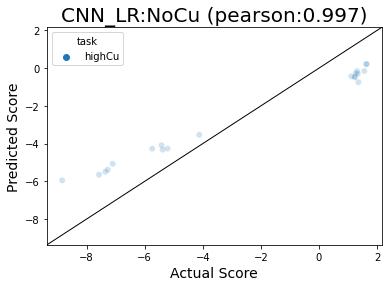

In [39]:
models = [
    #("LinearDeep_LR:NoCu",best_lin),
    ("CNN_LR:NoCu",best_cnn,DatasetSpec('ohe')),
]

genes = XYdf_smol['locus_tag'].values
task = "opt_best_LR:NoCu"

dfs = parity_pred_multi(models, genes, oracle_nocu,task,['highCu'],alt=False)

In [40]:
test_genes = ['EQU24_RS19315','EQU24_RS05885','EQU24_RS05905','EQU24_RS19520','EQU24_RS21000']
for gene in test_genes:
    seq = loc2seq[gene]
    seq_ohe = torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float()

    print(f"{gene} | pred:{best_cnn(seq_ohe).item()} | actu: {oracle_nocu[gene][0]}")

EQU24_RS19315 | pred:-2.77716326713562 | actu: 0.9095671757666924
EQU24_RS05885 | pred:-5.9526166915893555 | actu: -8.844506313926674
EQU24_RS05905 | pred:-5.649995803833008 | actu: -7.574592260367612
EQU24_RS19520 | pred:-4.322185516357422 | actu: -5.383131152368779
EQU24_RS21000 | pred:-4.27392578125 | actu: -5.746211486978689


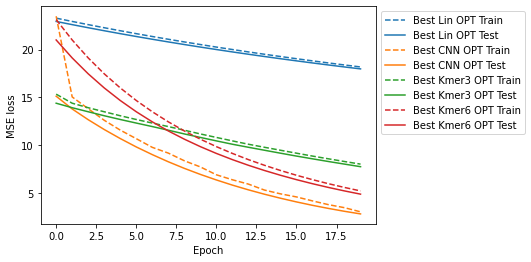

In [69]:
lin_opt_data_label = [((lin_ow.best_train_loss,lin_ow.best_test_loss),'Best Lin OPT')]
cnn_opt_data_label = [((cnn_ow.best_train_loss,cnn_ow.best_test_loss),'Best CNN OPT')]
kmer3_opt_data_label = [((kmer3_ow.best_train_loss,kmer3_ow.best_test_loss),'Best Kmer3 OPT')]
kmer6_opt_data_label = [((kmer6_ow.best_train_loss,kmer6_ow.best_test_loss),'Best Kmer6 OPT')]

def quick_loss_plot(data_label_list):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

    #plt.legend()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
quick_loss_plot(
    lin_opt_data_label + \
    cnn_opt_data_label + \
    kmer3_opt_data_label + \
    kmer6_opt_data_label 
)

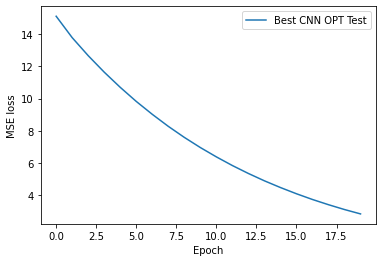

In [42]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    #plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

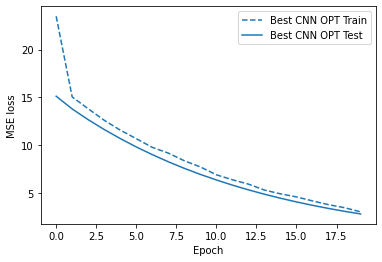

In [43]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

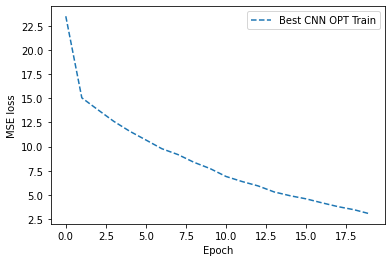

In [44]:
for i,((train_data,test_data),label) in enumerate(cnn_opt_data_label):
    plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
    #plt.plot(test_data,color=f"C{i}", label=f"{label} Test")

plt.legend()
plt.ylabel("MSE loss")
plt.xlabel("Epoch")
plt.show()

## Optuna: Kmer trial

In [45]:
# defining a deep linear model with Optuna
class Kmer_Opt(nn.ModuleList):
    def __init__(self, trial, num_kmers):
        super().__init__()
        
        self.num_kmers = num_kmers
        # Where the layers and dropouts will be stacked
        layers = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_hidden_fc = trial.suggest_int('n_hidden_fc',0,2)
        print("linear layer num:", n_hidden_fc)
        
        # +---------------------+
        # | Hidden FC Layers (N)|
        # +---------------------+
        prev_linear_node_num = num_kmers
        
        for i in range(1,n_hidden_fc+1):
            # Trial suggestions
            lini_fc_nodes = trial.suggest_categorical(f'lin{i}_fc_nodes',[8,16,32,64])
            lini_dropout = trial.suggest_categorical(f'lin{i}_dropout',[0,0.1,0.2,0.3])
            
            print(f"lin{i}_fc_nodes", lini_fc_nodes)
            print(f"lin{i}_dropout", lini_dropout)
            
            # Layer additions
            layers.append(nn.Linear(prev_linear_node_num, lini_fc_nodes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(lini_dropout))
            
            # value updates
            prev_linear_node_num = lini_fc_nodes
        
        # Add final prediction layer
        layers.append(nn.Linear(prev_linear_node_num, 1))
        
        # concat all the layers together
        self.lin = nn.Sequential(*layers)
        
            
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

### k=3

In [50]:
k3 = len(kmer3_train_dl.dataset.kmers)
eps=20
loss_func = torch.nn.MSELoss()
lr = 0.001

kmer3_ow = OptWrap(
    "Kmer3_Opt",
    Kmer_Opt,
    k3,
    eps,
    loss_func,
    lr,
    kmer3_train_dl, 
    kmer3_val_dl
)

kmer3_opt_study = optuna.create_study(direction="minimize")

kmer3_opt_study.optimize(kmer3_ow.optimize, n_trials=200)

print_study(kmer3_opt_study)

[I 2021-10-01 17:19:23,188] A new study created in memory with name: no-name-c3ba1c08-a0c3-40c1-8a24-0d0e849ea619
[I 2021-10-01 17:19:23,230] Trial 0 finished with value: 10.14526081085205 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,262] Trial 1 finished with value: 319791923200.0 and parameters: {'n_hidden_fc': 0}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,307] Trial 2 finished with value: 13.701822280883789 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.3, 'lin2_fc_nodes': 32, 'lin2_dropout': 0}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,347] Trial 3 finished with value: 11.54358196258545 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.1}. Best is trial 0 with value: 10.14526081085205.
[I 2021-10-01 17:19:23,386] Trial 4 finished with value: 9.332321166992188 and parameters:

linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.704496383666992
E1: 16.246723175048828
E2: 15.67937183380127
E3: 15.288970947265625
E4: 14.89726448059082
E5: 14.4025239944458
E6: 14.083139419555664
E7: 13.791485786437988
E8: 13.402236938476562
E9: 13.0971097946167
E10: 12.850848197937012
E11: 12.558420181274414
E12: 12.259596824645996
E13: 11.987159729003906
E14: 11.693161010742188
E15: 11.393122673034668
E16: 11.082099914550781
E17: 10.768416404724121
E18: 10.43585205078125
E19: 10.14526081085205
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 33.30673599243164
E1: 70.45000457763672
E2: 203.8574981689453
E3: 672.8302612304688
E4: 2312.692138671875
E5: 8039.1376953125
E6: 28029.240234375
E7: 97805.4375
E8: 341356.34375
E9: 1191456.25
E10:

[I 2021-10-01 17:19:23,396] Trial 6 pruned. 
[I 2021-10-01 17:19:23,401] Trial 7 pruned. 
[I 2021-10-01 17:19:23,405] Trial 8 pruned. 
[I 2021-10-01 17:19:23,411] Trial 9 pruned. 
[I 2021-10-01 17:19:23,417] Trial 10 pruned. 
[I 2021-10-01 17:19:23,465] Trial 11 finished with value: 9.00714111328125 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 11 with value: 9.00714111328125.
[I 2021-10-01 17:19:23,473] Trial 12 pruned. 
[I 2021-10-01 17:19:23,521] Trial 13 finished with value: 9.434021949768066 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 11 with value: 9.00714111328125.
[I 2021-10-01 17:19:23,528] Trial 14 pruned. 
[I 2021-10-01 17:19:23,535] Trial 15 pruned. 
[I 2021-10-01 17:19:23,543] Trial 16 pruned. 
[I 2021-10-01 17:19:23,550] Trial 17 pruned. 
[I 2021-10-01 17:19:23,557] Trial 18 pruned. 
[I 2021-10-01 17:19:23,567] Trial 19 pruned. 


linear layer num: 0
E0: 136.4683837890625
linear layer num: 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 64
lin2_dropout 0
E0: 20.54338264465332
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0
E0: 17.613794326782227
linear layer num: 2
lin1_fc_nodes 64
lin1_dropout 0.2
lin2_fc_nodes 64
lin2_dropout 0.3
E0: 18.954483032226562
linear layer num: 0
E0: 102.4970932006836
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.24906349182129
E1: 15.598401069641113
E2: 15.054513931274414
E3: 14.508435249328613
E4: 14.07666015625
E5: 13.650934219360352
E6: 13.272041320800781
E7: 12.935823440551758
E8: 12.598746299743652
E9: 12.129420280456543
E10: 11.71907901763916
E11: 11.33349609375
E12: 11.06812572479248
E13: 10.743998527526855
E14: 10.437407493591309
E15: 10.442831993103027
E16: 9.866435050964355
E17: 9.61903190612793
E18: 9.265589714050293
E19: 9.00714111328125
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    

[I 2021-10-01 17:19:23,616] Trial 20 finished with value: 8.791625022888184 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 20 with value: 8.791625022888184.
[I 2021-10-01 17:19:23,664] Trial 21 finished with value: 8.319297790527344 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 21 with value: 8.319297790527344.
[I 2021-10-01 17:19:23,712] Trial 22 finished with value: 7.7808098793029785 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,720] Trial 23 pruned. 
[I 2021-10-01 17:19:23,738] Trial 24 pruned. 
[I 2021-10-01 17:19:23,747] Trial 25 pruned. 
[I 2021-10-01 17:19:23,753] Trial 26 pruned. 
[I 2021-10-01 17:19:23,772] Trial 27 pruned. 


E9: 11.963896751403809
E10: 11.537856101989746
E11: 11.221864700317383
E12: 10.8515625
E13: 10.55411434173584
E14: 10.209912300109863
E15: 9.986151695251465
E16: 9.61059856414795
E17: 9.35737133026123
E18: 9.031643867492676
E19: 8.791625022888184
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.794466972351074
E1: 15.022635459899902
E2: 14.417773246765137
E3: 13.862139701843262
E4: 13.412200927734375
E5: 12.95438289642334
E6: 12.529013633728027
E7: 12.132630348205566
E8: 11.767160415649414
E9: 11.349980354309082
E10: 10.963563919067383
E11: 10.60398006439209
E12: 10.398154258728027
E13: 10.064042091369629
E14: 9.699376106262207
E15: 9.389540672302246
E16: 9.163844108581543
E17: 8.829779624938965
E18: 8.5692882537841

[I 2021-10-01 17:19:23,820] Trial 28 finished with value: 8.298131942749023 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,827] Trial 29 pruned. 
[I 2021-10-01 17:19:23,837] Trial 30 pruned. 
[I 2021-10-01 17:19:23,845] Trial 31 pruned. 
[I 2021-10-01 17:19:23,893] Trial 32 finished with value: 8.950698852539062 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,941] Trial 33 finished with value: 8.531671524047852 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 22 with value: 7.7808098793029785.
[I 2021-10-01 17:19:23,949] Trial 34 pruned. 
[I 2021-10-01 17:19:23,958] Trial 35 pruned. 


E8: 12.161229133605957
E9: 11.875584602355957
E10: 11.429688453674316
E11: 11.073150634765625
E12: 10.729435920715332
E13: 10.350066184997559
E14: 9.956184387207031
E15: 9.623641014099121
E16: 9.322882652282715
E17: 8.955925941467285
E18: 8.637189865112305
E19: 8.298131942749023
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 85.29509735107422
linear layer num: 2
lin1_fc_nodes 64
lin1_dropout 0.3
lin2_fc_nodes 16
lin2_dropout 0.3
E0: 27.150434494018555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.91974639892578
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.106802940368652
E1: 14.7008056640625
E2: 14.298646926879883
E3: 13.954269409179688
E4: 13.561419486999512
E5: 13.183138847351074
E6: 12.867965698242188
E7: 12.54860973

[I 2021-10-01 17:19:24,008] Trial 36 finished with value: 7.155661106109619 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,017] Trial 37 pruned. 
[I 2021-10-01 17:19:24,036] Trial 38 pruned. 
[I 2021-10-01 17:19:24,044] Trial 39 pruned. 
[I 2021-10-01 17:19:24,054] Trial 40 pruned. 
[I 2021-10-01 17:19:24,102] Trial 41 finished with value: 7.999876499176025 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,129] Trial 42 pruned. 
[I 2021-10-01 17:19:24,148] Trial 43 pruned. 
[I 2021-10-01 17:19:24,156] Trial 44 pruned. 
[I 2021-10-01 17:19:24,165] Trial 45 pruned. 


E15: 8.318577766418457
E16: 7.970571994781494
E17: 7.684084415435791
E18: 7.427252292633057
E19: 7.155661106109619
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.601713180541992
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.1
E0: 15.659052848815918
E1: 14.75934886932373
E2: 14.378700256347656
E3: 14.184646606445312
E4: 13.730549812316895
E5: 13.49591064453125
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 22.691696166992188
linear layer num: 2
lin1_fc_nodes 32
lin1_dropout 0.1
lin2_fc_nodes 32
lin2_dropout 0.2
E0: 21.19795036315918
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.859646797180176
E1: 14.29771900177002
E2: 13.886507987976074
E3: 13.50493049621582
E4: 13.088945388793945
E5

[I 2021-10-01 17:19:24,214] Trial 46 finished with value: 8.332167625427246 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 36 with value: 7.155661106109619.
[I 2021-10-01 17:19:24,222] Trial 47 pruned. 
[I 2021-10-01 17:19:24,270] Trial 48 finished with value: 6.786139965057373 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 48 with value: 6.786139965057373.
[I 2021-10-01 17:19:24,276] Trial 49 pruned. 
[I 2021-10-01 17:19:24,286] Trial 50 pruned. 
[I 2021-10-01 17:19:24,334] Trial 51 finished with value: 8.044778823852539 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 48 with value: 6.786139965057373.
[I 2021-10-01 17:19:24,381] Trial 52 finished with value: 6.4608988761901855 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,390] Trial 53 pruned. 


E14: 9.708586692810059
E15: 9.41455078125
E16: 9.142443656921387
E17: 8.849611282348633
E18: 8.57487678527832
E19: 8.332167625427246
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.1
E0: 15.881573677062988
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.560935974121094
E1: 13.5724515914917
E2: 13.046635627746582
E3: 12.579368591308594
E4: 12.118369102478027
E5: 11.660914421081543
E6: 11.21399211883545
E7: 10.808459281921387
E8: 10.417556762695312
E9: 10.037882804870605
E10: 9.66807746887207
E11: 9.299227714538574
E12: 8.94670581817627
E13: 8.60990047454834
E14: 8.281250953674316
E15: 7.9637451171875
E16: 7.659767150878906
E17: 7.3617401123046875
E18: 7.068759441375732
E19: 6.786139965057373
****Model Arch ****
Km

[I 2021-10-01 17:19:24,419] Trial 54 pruned. 
[I 2021-10-01 17:19:24,428] Trial 55 pruned. 
[I 2021-10-01 17:19:24,436] Trial 56 pruned. 
[I 2021-10-01 17:19:24,444] Trial 57 pruned. 
[I 2021-10-01 17:19:24,453] Trial 58 pruned. 
[I 2021-10-01 17:19:24,461] Trial 59 pruned. 
[I 2021-10-01 17:19:24,469] Trial 60 pruned. 
[I 2021-10-01 17:19:24,478] Trial 61 pruned. 
[I 2021-10-01 17:19:24,486] Trial 62 pruned. 
[I 2021-10-01 17:19:24,495] Trial 63 pruned. 
[I 2021-10-01 17:19:24,503] Trial 64 pruned. 
[I 2021-10-01 17:19:24,512] Trial 65 pruned. 
[I 2021-10-01 17:19:24,520] Trial 66 pruned. 
[I 2021-10-01 17:19:24,529] Trial 67 pruned. 
[I 2021-10-01 17:19:24,538] Trial 68 pruned. 
[I 2021-10-01 17:19:24,547] Trial 69 pruned. 
[I 2021-10-01 17:19:24,555] Trial 70 pruned. 
[I 2021-10-01 17:19:24,564] Trial 71 pruned. 
[I 2021-10-01 17:19:24,573] Trial 72 pruned. 
[I 2021-10-01 17:19:24,581] Trial 73 pruned. 


E3: 13.449113845825195
E4: 13.13891315460205
E5: 12.85044002532959
E6: 12.56684398651123
E7: 12.285834312438965
E8: 12.01468563079834
E9: 11.735457420349121
E10: 11.456623077392578
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.621109008789062
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 18.499738693237305
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.774494171142578
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 17.995771408081055
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0
E0: 17.54142951965332
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 16.986568450927734
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.30466651916504
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.845575332641602
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 15.790133476257324
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.798181533813477
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 17.6715278

[I 2021-10-01 17:19:24,631] Trial 74 finished with value: 7.091526985168457 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,640] Trial 75 pruned. 
[I 2021-10-01 17:19:24,648] Trial 76 pruned. 
[I 2021-10-01 17:19:24,657] Trial 77 pruned. 
[I 2021-10-01 17:19:24,666] Trial 78 pruned. 
[I 2021-10-01 17:19:24,675] Trial 79 pruned. 
[I 2021-10-01 17:19:24,681] Trial 80 pruned. 
[I 2021-10-01 17:19:24,690] Trial 81 pruned. 
[I 2021-10-01 17:19:24,699] Trial 82 pruned. 
[I 2021-10-01 17:19:24,708] Trial 83 pruned. 
[I 2021-10-01 17:19:24,717] Trial 84 pruned. 
[I 2021-10-01 17:19:24,766] Trial 85 pruned. 


E8: 10.863921165466309
E9: 10.547126770019531
E10: 10.122227668762207
E11: 9.779199600219727
E12: 9.386454582214355
E13: 9.082844734191895
E14: 8.711800575256348
E15: 8.402756690979004
E16: 8.098113059997559
E17: 7.91177225112915
E18: 7.543109893798828
E19: 7.091526985168457
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.268047332763672
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 17.011619567871094
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.353270530700684
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.2
E0: 20.227827072143555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.488049507141113
linear layer num: 0
E0: 30.686756134033203
linear layer num: 1
lin1_fc_nodes

[I 2021-10-01 17:19:24,816] Trial 86 finished with value: 7.8123955726623535 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.3}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,825] Trial 87 pruned. 
[I 2021-10-01 17:19:24,834] Trial 88 pruned. 
[I 2021-10-01 17:19:24,843] Trial 89 pruned. 
[I 2021-10-01 17:19:24,852] Trial 90 pruned. 
[I 2021-10-01 17:19:24,901] Trial 91 finished with value: 7.003076076507568 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:24,909] Trial 92 pruned. 
[I 2021-10-01 17:19:24,918] Trial 93 pruned. 
[I 2021-10-01 17:19:24,927] Trial 94 pruned. 
[I 2021-10-01 17:19:24,936] Trial 95 pruned. 
[I 2021-10-01 17:19:24,945] Trial 96 pruned. 
[I 2021-10-01 17:19:24,954] Trial 97 pruned. 
[I 2021-10-01 17:19:24,963] Trial 98 pruned. 
[I 2021-10-01 17:19:24,972] Trial 99 pruned. 
[I 2021-10-01 17:19:24,981] Trial 100 prune

E16: 8.342015266418457
E17: 8.21768856048584
E18: 7.959161281585693
E19: 7.8123955726623535
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.21104621887207
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.139732360839844
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 16.973203659057617
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 19.02981948852539
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 13.914422988891602
E1: 13.281071662902832
E2: 12.763304710388184
E3: 12.260284423828125
E4: 11.814424514770508
E5: 11.391722679138184
E6: 10.995378494262695
E7: 10.61577033996582
E8: 10.24760627746582
E9: 9.886743545532227
E10: 9.5495023727417
E11: 9.224331855773926
E12: 8.9178075790

[I 2021-10-01 17:19:25,058] Trial 104 finished with value: 7.217438697814941 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,068] Trial 105 pruned. 
[I 2021-10-01 17:19:25,077] Trial 106 pruned. 
[I 2021-10-01 17:19:25,087] Trial 107 pruned. 
[I 2021-10-01 17:19:25,096] Trial 108 pruned. 
[I 2021-10-01 17:19:25,105] Trial 109 pruned. 
[I 2021-10-01 17:19:25,115] Trial 110 pruned. 
[I 2021-10-01 17:19:25,124] Trial 111 pruned. 
[I 2021-10-01 17:19:25,133] Trial 112 pruned. 
[I 2021-10-01 17:19:25,142] Trial 113 pruned. 
[I 2021-10-01 17:19:25,152] Trial 114 pruned. 
[I 2021-10-01 17:19:25,161] Trial 115 pruned. 
[I 2021-10-01 17:19:25,170] Trial 116 pruned. 
[I 2021-10-01 17:19:25,180] Trial 117 pruned. 
[I 2021-10-01 17:19:25,189] Trial 118 pruned. 
[I 2021-10-01 17:19:25,198] Trial 119 pruned. 
[I 2021-10-01 17:19:25,207] Trial 120 pruned. 


linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 13.986319541931152
E1: 13.514566421508789
E2: 13.043426513671875
E3: 12.565176963806152
E4: 12.099868774414062
E5: 11.758292198181152
E6: 11.308094024658203
E7: 10.962508201599121
E8: 10.565380096435547
E9: 10.172987937927246
E10: 9.803511619567871
E11: 9.494755744934082
E12: 9.163331985473633
E13: 8.852893829345703
E14: 8.589985847473145
E15: 8.2885160446167
E16: 7.971459865570068
E17: 7.700563907623291
E18: 7.472161769866943
E19: 7.217438697814941
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E0: 17.910490036010742
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 18.459514617919922
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.5273380279

[I 2021-10-01 17:19:25,217] Trial 121 pruned. 
[I 2021-10-01 17:19:25,227] Trial 122 pruned. 
[I 2021-10-01 17:19:25,268] Trial 123 pruned. 
[I 2021-10-01 17:19:25,277] Trial 124 pruned. 
[I 2021-10-01 17:19:25,287] Trial 125 pruned. 
[I 2021-10-01 17:19:25,296] Trial 126 pruned. 
[I 2021-10-01 17:19:25,306] Trial 127 pruned. 
[I 2021-10-01 17:19:25,316] Trial 128 pruned. 
[I 2021-10-01 17:19:25,325] Trial 129 pruned. 
[I 2021-10-01 17:19:25,335] Trial 130 pruned. 
[I 2021-10-01 17:19:25,345] Trial 131 pruned. 
[I 2021-10-01 17:19:25,354] Trial 132 pruned. 
[I 2021-10-01 17:19:25,405] Trial 133 finished with value: 7.187598705291748 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.


0.1
E0: 15.013635635375977
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.3498477935791
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.168037414550781
E1: 13.737034797668457
E2: 13.34362506866455
E3: 12.982975959777832
E4: 12.623672485351562
E5: 12.276124954223633
E6: 11.978072166442871
E7: 11.673049926757812
E8: 11.390196800231934
E9: 11.086517333984375
E10: 10.768084526062012
E11: 10.49181842803955
E12: 10.20185375213623
E13: 9.919876098632812
E14: 9.695876121520996
E15: 9.447629928588867
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.91285514831543
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E0: 15.465609550476074
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.98284912109375
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.3
E0: 15.236373901367188
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.281468391418457
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 20.145185470581055
linear layer num: 1
l

[I 2021-10-01 17:19:25,415] Trial 134 pruned. 
[I 2021-10-01 17:19:25,426] Trial 135 pruned. 
[I 2021-10-01 17:19:25,436] Trial 136 pruned. 
[I 2021-10-01 17:19:25,487] Trial 137 finished with value: 7.788560390472412 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,497] Trial 138 pruned. 
[I 2021-10-01 17:19:25,507] Trial 139 pruned. 
[I 2021-10-01 17:19:25,517] Trial 140 pruned. 
[I 2021-10-01 17:19:25,527] Trial 141 pruned. 
[I 2021-10-01 17:19:25,537] Trial 142 pruned. 
[I 2021-10-01 17:19:25,587] Trial 143 finished with value: 7.340812683105469 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,598] Trial 144 pruned. 
[I 2021-10-01 17:19:25,607] Trial 145 pruned. 


E0: 17.75627326965332
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.41872215270996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.661160469055176
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.473187446594238
E1: 13.592291831970215
E2: 13.149765014648438
E3: 12.767729759216309
E4: 12.398788452148438
E5: 12.036908149719238
E6: 11.681888580322266
E7: 11.330662727355957
E8: 10.995680809020996
E9: 10.640463829040527
E10: 10.31186580657959
E11: 9.988055229187012
E12: 9.654829025268555
E13: 9.349745750427246
E14: 9.090505599975586
E15: 8.804829597473145
E16: 8.561869621276855
E17: 8.31284236907959
E18: 8.056017875671387
E19: 7.788560390472412
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0

[I 2021-10-01 17:19:25,617] Trial 146 pruned. 
[I 2021-10-01 17:19:25,627] Trial 147 pruned. 
[I 2021-10-01 17:19:25,636] Trial 148 pruned. 
[I 2021-10-01 17:19:25,687] Trial 149 finished with value: 7.170773983001709 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.2}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,697] Trial 150 pruned. 
[I 2021-10-01 17:19:25,707] Trial 151 pruned. 
[I 2021-10-01 17:19:25,716] Trial 152 pruned. 
[I 2021-10-01 17:19:25,726] Trial 153 pruned. 
[I 2021-10-01 17:19:25,736] Trial 154 pruned. 
[I 2021-10-01 17:19:25,746] Trial 155 pruned. 
[I 2021-10-01 17:19:25,756] Trial 156 pruned. 
[I 2021-10-01 17:19:25,766] Trial 157 pruned. 
[I 2021-10-01 17:19:25,776] Trial 158 pruned. 
[I 2021-10-01 17:19:25,786] Trial 159 pruned. 
[I 2021-10-01 17:19:25,796] Trial 160 pruned. 
[I 2021-10-01 17:19:25,806] Trial 161 pruned. 


E0: 16.807111740112305
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.75172996520996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 16.21182632446289
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 14.833887100219727
E1: 14.16074275970459
E2: 13.62303352355957
E3: 13.088075637817383
E4: 12.674349784851074
E5: 12.15632438659668
E6: 11.78692626953125
E7: 11.148016929626465
E8: 10.758713722229004
E9: 10.270929336547852
E10: 9.83701229095459
E11: 9.537066459655762
E12: 9.184175491333008
E13: 8.904250144958496
E14: 8.553901672363281
E15: 8.263402938842773
E16: 7.921580791473389
E17: 7.631932258605957
E18: 7.378768444061279
E19: 7.170773983001709
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 16
lin1_dropout 0.2
E

[I 2021-10-01 17:19:25,840] Trial 162 pruned. 
[I 2021-10-01 17:19:25,849] Trial 163 pruned. 
[I 2021-10-01 17:19:25,859] Trial 164 pruned. 
[I 2021-10-01 17:19:25,874] Trial 165 pruned. 
[I 2021-10-01 17:19:25,924] Trial 166 finished with value: 7.499787330627441 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:25,935] Trial 167 pruned. 
[I 2021-10-01 17:19:25,945] Trial 168 pruned. 
[I 2021-10-01 17:19:25,955] Trial 169 pruned. 
[I 2021-10-01 17:19:25,965] Trial 170 pruned. 
[I 2021-10-01 17:19:25,975] Trial 171 pruned. 


E2: 13.672314643859863
E3: 13.230633735656738
E4: 12.856225967407227
E5: 12.532694816589355
E6: 12.250861167907715
E7: 11.9097318649292
E8: 11.539809226989746
E9: 11.237548828125
E10: 10.893942832946777
E11: 10.580978393554688
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.97015380859375
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.502260208129883
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.623443603515625
E1: 14.225921630859375
E2: 13.850749015808105
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 14.285687446594238
E1: 13.49170207977295
E2: 13.122896194458008
E3: 12.732996940612793
E4: 12.35578441619873
E5: 11.988916397094727
E6: 11.600897789001465
E7: 11.264609336853027
E8: 10.873717308044434
E9: 10.595678329467773
E10: 10.161256790161133
E11: 9.789385795593262
E12: 9.535435676574707
E13: 9.24974250793457
E14: 9.13232707977295
E15: 8.70464038848877
E16: 8.34375286102295
E17: 8.101666450500488
E18: 7.804446697235107
E19: 7.499787

[I 2021-10-01 17:19:26,026] Trial 172 finished with value: 7.437587261199951 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 64, 'lin1_dropout': 0.1}. Best is trial 52 with value: 6.4608988761901855.
[I 2021-10-01 17:19:26,036] Trial 173 pruned. 
[I 2021-10-01 17:19:26,047] Trial 174 pruned. 
[I 2021-10-01 17:19:26,057] Trial 175 pruned. 
[I 2021-10-01 17:19:26,067] Trial 176 pruned. 
[I 2021-10-01 17:19:26,077] Trial 177 pruned. 
[I 2021-10-01 17:19:26,087] Trial 178 pruned. 
[I 2021-10-01 17:19:26,097] Trial 179 pruned. 
[I 2021-10-01 17:19:26,107] Trial 180 pruned. 
[I 2021-10-01 17:19:26,117] Trial 181 pruned. 
[I 2021-10-01 17:19:26,127] Trial 182 pruned. 
[I 2021-10-01 17:19:26,137] Trial 183 pruned. 
[I 2021-10-01 17:19:26,148] Trial 184 pruned. 
[I 2021-10-01 17:19:26,158] Trial 185 pruned. 
[I 2021-10-01 17:19:26,168] Trial 186 pruned. 
[I 2021-10-01 17:19:26,179] Trial 187 pruned. 
[I 2021-10-01 17:19:26,189] Trial 188 pruned. 
[I 2021-10-01 17:19:26,199] Trial 189 pruned

E18: 7.64076566696167
E19: 7.437587261199951
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.93827247619629
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 17.605491638183594
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.1
E0: 19.541200637817383
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.915815353393555
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.418108940124512
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 15.237460136413574
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.44956111907959
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 16.991073608398438
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.517292022705078
lin

[I 2021-10-01 17:19:26,230] Trial 192 pruned. 
[I 2021-10-01 17:19:26,241] Trial 193 pruned. 
[I 2021-10-01 17:19:26,251] Trial 194 pruned. 
[I 2021-10-01 17:19:26,262] Trial 195 pruned. 
[I 2021-10-01 17:19:26,273] Trial 196 pruned. 
[I 2021-10-01 17:19:26,284] Trial 197 pruned. 
[I 2021-10-01 17:19:26,295] Trial 198 pruned. 
[I 2021-10-01 17:19:26,305] Trial 199 pruned. 


linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.736579895019531
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.678875923156738
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 17.0250186920166
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.536221504211426
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 15.572502136230469
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.1
E0: 16.60329246520996
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 14.854657173156738
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.923212051391602
Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  171
  Number of complete trials:  29
Best trial:
  Value :  6.4608988761901855
  Number:  52
  Params: 
    n_hidden_fc: 1
    lin1_fc_nodes: 64
    lin1_dropout: 0


In [51]:
best_kmer3 = kmer3_ow.retrain_best(kmer3_opt_study.best_trial)

linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 14.389915466308594
E1: 13.919344902038574
E2: 13.497207641601562
E3: 13.080514907836914
E4: 12.688490867614746
E5: 12.315924644470215
E6: 11.94937801361084
E7: 11.569273948669434
E8: 11.178973197937012
E9: 10.813311576843262
E10: 10.452986717224121
E11: 10.102057456970215
E12: 9.785041809082031
E13: 9.475157737731934
E14: 9.16741943359375
E15: 8.864517211914062
E16: 8.57769775390625
E17: 8.295851707458496
E18: 8.024382591247559
E19: 7.756619453430176


### k=6

In [48]:
k6 = len(kmer6_train_dl.dataset.kmers)
eps=20
loss_func = torch.nn.MSELoss()
lr = 0.001

kmer6_ow = OptWrap(
    "Kmer6_Opt",
    Kmer_Opt,
    k6,
    eps,
    loss_func,
    lr,
    kmer6_train_dl, 
    kmer6_val_dl
)

kmer6_opt_study = optuna.create_study(direction="minimize")

kmer6_opt_study.optimize(kmer6_ow.optimize, n_trials=200)

print_study(kmer6_opt_study)

[I 2021-10-01 17:19:11,399] A new study created in memory with name: no-name-0c0202f2-433f-45ec-bc5e-0e81fa4ae966
[I 2021-10-01 17:19:11,463] Trial 0 finished with value: 19.26093864440918 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 32, 'lin1_dropout': 0.1, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.2}. Best is trial 0 with value: 19.26093864440918.
[I 2021-10-01 17:19:11,508] Trial 1 finished with value: 4.7541937828063965 and parameters: {'n_hidden_fc': 0}. Best is trial 1 with value: 4.7541937828063965.
[I 2021-10-01 17:19:11,560] Trial 2 finished with value: 15.277572631835938 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.1}. Best is trial 1 with value: 4.7541937828063965.


linear layer num: 2
lin1_fc_nodes 32
lin1_dropout 0.1
lin2_fc_nodes 8
lin2_dropout 0.2
E0: 21.215728759765625
E1: 21.106233596801758
E2: 21.006132125854492
E3: 20.89723014831543
E4: 20.792800903320312
E5: 20.70549774169922
E6: 20.629335403442383
E7: 20.51909828186035
E8: 20.410749435424805
E9: 20.340660095214844
E10: 20.244552612304688
E11: 20.154476165771484
E12: 20.04886245727539
E13: 19.945432662963867
E14: 19.841703414916992
E15: 19.73967170715332
E16: 19.63799476623535
E17: 19.514699935913086
E18: 19.385103225708008
E19: 19.26093864440918
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.99019432067871
E1: 19.05830383300

[I 2021-10-01 17:19:11,619] Trial 3 finished with value: 21.26307487487793 and parameters: {'n_hidden_fc': 2, 'lin1_fc_nodes': 8, 'lin1_dropout': 0, 'lin2_fc_nodes': 8, 'lin2_dropout': 0.1}. Best is trial 1 with value: 4.7541937828063965.
[I 2021-10-01 17:19:11,663] Trial 4 finished with value: 4.73805046081543 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,720] Trial 5 finished with value: 15.023096084594727 and parameters: {'n_hidden_fc': 1, 'lin1_fc_nodes': 16, 'lin1_dropout': 0.2}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,768] Trial 6 finished with value: 4.8243584632873535 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,776] Trial 7 pruned. 
[I 2021-10-01 17:19:11,782] Trial 8 pruned. 
[I 2021-10-01 17:19:11,790] Trial 9 pruned. 


E14: 21.496007919311523
E15: 21.45119285583496
E16: 21.406192779541016
E17: 21.35616111755371
E18: 21.309938430786133
E19: 21.26307487487793
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.397855758666992
E1: 18.573997497558594
E2: 16.96070671081543
E3: 15.528109550476074
E4: 14.2510986328125
E5: 13.10851764678955
E6: 12.082504272460938
E7: 11.157952308654785
E8: 10.322044372558594
E9: 9.563886642456055
E10: 8.874183654785156
E11: 8.244990348815918
E12: 7.669490337371826
E13: 7.141810894012451
E14: 6.656887054443359
E15: 6.210323810577393
E16: 5.7982964515686035
E17: 5.4174675941467285
E18: 5.064910888671875
E19: 4.738050460815

[I 2021-10-01 17:19:11,843] Trial 10 finished with value: 4.861721992492676 and parameters: {'n_hidden_fc': 0}. Best is trial 4 with value: 4.73805046081543.
[I 2021-10-01 17:19:11,896] Trial 11 finished with value: 4.689782619476318 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:11,948] Trial 12 finished with value: 4.755666732788086 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:11,955] Trial 13 pruned. 
[I 2021-10-01 17:19:12,007] Trial 14 finished with value: 4.717681884765625 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.


E4: 14.510184288024902
E5: 13.354103088378906
E6: 12.315584182739258
E7: 11.379389762878418
E8: 10.532599449157715
E9: 9.764226913452148
E10: 9.064909934997559
E11: 8.426640510559082
E12: 7.842550754547119
E13: 7.306727886199951
E14: 6.814066410064697
E15: 6.360142707824707
E16: 5.941106796264648
E17: 5.553596019744873
E18: 5.194665431976318
E19: 4.861721992492676
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.428707122802734
E1: 18.57590103149414
E2: 16.940458297729492
E3: 15.491190910339355
E4: 14.20190715789795
E5: 13.050570487976074
E6: 12.018603324890137
E7: 11.090311050415039
E8: 10.252402305603027
E9: 9.493597984313965
E10: 8.804287910461426
E11: 8.176279067993164
E12: 7.602548122406006
E13: 7.077065944671631
E14: 6.594632625579834
E15: 6.150752544403076
E16: 5.741523265838623
E17: 5.363541603088379
E18: 5.013832092285156
E19: 4.689782619476318
****Model Arch ***

[I 2021-10-01 17:19:12,017] Trial 15 pruned. 
[I 2021-10-01 17:19:12,069] Trial 16 finished with value: 4.7288737297058105 and parameters: {'n_hidden_fc': 0}. Best is trial 11 with value: 4.689782619476318.
[I 2021-10-01 17:19:12,079] Trial 17 pruned. 
[I 2021-10-01 17:19:12,131] Trial 18 finished with value: 4.63311243057251 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,140] Trial 19 pruned. 
[I 2021-10-01 17:19:12,191] Trial 20 finished with value: 4.710566997528076 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.


linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3
E0: 21.580780029296875
linear layer num: 0
E0: 20.56656837463379
E1: 18.701475143432617
E2: 17.055356979370117
E3: 15.596778869628906
E4: 14.299325942993164
E5: 13.140785217285156
E6: 12.102431297302246
E7: 11.16844654083252
E8: 10.325439453125
E9: 9.56203842163086
E10: 8.868570327758789
E11: 8.236776351928711
E12: 7.659585475921631
E13: 7.130925178527832
E14: 6.645561218261719
E15: 6.198968410491943
E16: 5.78721809387207
E17: 5.406886577606201
E18: 5.054980754852295
E19: 4.7288737297058105
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 32
lin1_dropout 0.3
E0: 21.545820236206055
linear layer num: 0
E0: 19.96463966369629
E1: 18.174365997314453
E2: 16.59166145324707
E3: 15.186985969543457
E4: 13.935505867004395
E5: 12.816307067871094
E6: 11.811749458312988
E7: 10.90691089630127
E8: 10.089139938354492
E9: 9.34769

[I 2021-10-01 17:19:12,244] Trial 21 finished with value: 4.684104919433594 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,296] Trial 22 finished with value: 4.690818786621094 and parameters: {'n_hidden_fc': 0}. Best is trial 18 with value: 4.63311243057251.
[I 2021-10-01 17:19:12,303] Trial 23 pruned. 
[I 2021-10-01 17:19:12,355] Trial 24 finished with value: 4.5797014236450195 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,366] Trial 25 pruned. 


E6: 12.04304027557373
E7: 11.110607147216797
E8: 10.268953323364258
E9: 9.506763458251953
E10: 8.814414978027344
E11: 8.183680534362793
E12: 7.607517242431641
E13: 7.079870700836182
E14: 6.595520973205566
E15: 6.149950981140137
E16: 5.739235877990723
E17: 5.359957695007324
E18: 5.0091233253479
E19: 4.684104919433594
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.1912899017334
E1: 18.38100242614746
E2: 16.78068733215332
E3: 15.360447883605957
E4: 14.095152854919434
E5: 12.963641166687012
E6: 11.948063850402832
E7: 11.033320426940918
E8: 10.206616401672363
E9: 9.457076072692871
E10: 8.775428771972656
E11: 8.15375804901123
E12: 7.585264682769775
E13: 7.064113616943359
E14: 6.585258483886719
E15: 6.144334316253662
E16: 5.737541675567627
E17: 5.361568450927734
E18: 5.013510227203369
E19: 4.690818786621094
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_

[I 2021-10-01 17:19:12,418] Trial 26 finished with value: 4.6180901527404785 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,470] Trial 27 finished with value: 4.714041709899902 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,479] Trial 28 pruned. 
[I 2021-10-01 17:19:12,486] Trial 29 pruned. 
[I 2021-10-01 17:19:12,538] Trial 30 finished with value: 4.66161584854126 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,591] Trial 31 finished with value: 4.699704647064209 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.


E18: 4.935652256011963
E19: 4.6180901527404785
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.376760482788086
E1: 18.54554557800293
E2: 16.926944732666016
E3: 15.490686416625977
E4: 14.211320877075195
E5: 13.06742000579834
E6: 12.040902137756348
E7: 11.116477012634277
E8: 10.281181335449219
E9: 9.523999214172363
E10: 8.835545539855957
E11: 8.207793235778809
E12: 7.6338629722595215
E13: 7.107837200164795
E14: 6.624609470367432
E15: 6.179752349853516
E16: 5.769423961639404
E17: 5.390261173248291
E18: 5.03933048248291
E19: 4.714041709899902
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.1
E0: 21.665122985839844
linear layer num: 0
E0: 20.680330276489258
linear layer num: 0
E0: 19.785686492919922
E1: 18.032730102539062
E2: 16.48108291

[I 2021-10-01 17:19:12,644] Trial 32 finished with value: 4.587696552276611 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,696] Trial 33 finished with value: 4.5929412841796875 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,749] Trial 34 finished with value: 4.6532301902771 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,802] Trial 35 finished with value: 4.581961631774902 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,811] Trial 36 pruned. 


E8: 10.010952949523926
E9: 9.27157211303711
E10: 8.599836349487305
E11: 7.987758636474609
E12: 7.428509712219238
E13: 6.9162187576293945
E14: 6.445827484130859
E15: 6.012961387634277
E16: 5.613822937011719
E17: 5.245103359222412
E18: 4.903907299041748
E19: 4.587696552276611
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.00502586364746
E1: 18.18828773498535
E2: 16.58513832092285
E3: 15.164875984191895
E4: 13.901727676391602
E5: 12.774012565612793
E6: 11.763453483581543
E7: 10.854615211486816
E8: 10.034433364868164
E9: 9.2918119430542
E10: 8.617315292358398
E11: 8.002886772155762
E12: 7.4416327476501465
E13: 6.9276299476623535
E14: 6.455776214599609
E15: 6.021658897399902
E16: 5.621448040008545
E17: 5.2518110275268555
E18: 4.909829616546631
E19: 4.5929412841796875
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=Tru

[I 2021-10-01 17:19:12,818] Trial 37 pruned. 
[I 2021-10-01 17:19:12,825] Trial 38 pruned. 
[I 2021-10-01 17:19:12,834] Trial 39 pruned. 
[I 2021-10-01 17:19:12,845] Trial 40 pruned. 
[I 2021-10-01 17:19:12,864] Trial 41 pruned. 
[I 2021-10-01 17:19:12,870] Trial 42 pruned. 
[I 2021-10-01 17:19:12,884] Trial 43 pruned. 
[I 2021-10-01 17:19:12,936] Trial 44 finished with value: 4.627091884613037 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:12,944] Trial 45 pruned. 
[I 2021-10-01 17:19:12,997] Trial 46 finished with value: 4.703074932098389 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,005] Trial 47 pruned. 
[I 2021-10-01 17:19:13,021] Trial 48 pruned. 


linear layer num: 0
E0: 20.495580673217773
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0.3
E0: 23.555618286132812
linear layer num: 2
lin1_fc_nodes 16
lin1_dropout 0.1
lin2_fc_nodes 32
lin2_dropout 0.3
E0: 23.012537002563477
linear layer num: 0
E0: 20.335567474365234
E1: 18.51275062561035
E2: 16.901348114013672
E3: 15.471244812011719
E4: 14.197138786315918
E5: 13.057721138000488
linear layer num: 0
E0: 20.673660278320312
linear layer num: 0
E0: 20.214719772338867
E1: 18.45484161376953
E2: 16.893163681030273
E3: 15.501996040344238
linear layer num: 0
E0: 19.98048973083496
E1: 18.1776180267334
E2: 16.585678100585938
E3: 15.174430847167969
E4: 13.918478965759277
E5: 12.7964506149292
E6: 11.790339469909668
E7: 10.884918212890625
E8: 10.067301750183105
E9: 9.32654857635498
E10: 8.653343200683594
E11: 8.03973388671875
E12: 7.478909969329834
E13: 6.965022563934326
E14: 6.493026256561279
E15: 6.058558940887451
E16: 5.657833576202393
E17: 5.287547588348389
E18: 4.94481086730957
E19: 4.6270

[I 2021-10-01 17:19:13,028] Trial 49 pruned. 
[I 2021-10-01 17:19:13,039] Trial 50 pruned. 
[I 2021-10-01 17:19:13,092] Trial 51 finished with value: 4.681273460388184 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,100] Trial 52 pruned. 
[I 2021-10-01 17:19:13,107] Trial 53 pruned. 
[I 2021-10-01 17:19:13,160] Trial 54 finished with value: 4.652487754821777 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,213] Trial 55 finished with value: 4.6947245597839355 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,222] Trial 56 pruned. 


linear layer num: 0
E0: 20.759450912475586
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0.2
E0: 22.008752822875977
linear layer num: 0
E0: 20.009849548339844
E1: 18.23175621032715
E2: 16.657791137695312
E3: 15.259100914001465
E4: 14.011423110961914
E5: 12.894299507141113
E6: 11.890463829040527
E7: 10.985298156738281
E8: 10.166399002075195
E9: 9.42321491241455
E10: 8.746744155883789
E11: 8.129281997680664
E12: 7.564216136932373
E13: 7.0458526611328125
E14: 6.569268703460693
E15: 6.13019323348999
E16: 5.724910736083984
E17: 5.350173473358154
E18: 5.0031304359436035
E19: 4.681273460388184
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.070180892944336
linear layer num: 0
E0: 20.65205955505371
linear layer num: 0
E0: 20.170942306518555
E1: 18.34962272644043
E2: 16.741056442260742
E3: 15.314804077148438
E4: 14.045295715332031
E5: 12.911005020141602
E6: 11.893790245056152

[I 2021-10-01 17:19:13,275] Trial 57 finished with value: 4.66987943649292 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,328] Trial 58 finished with value: 4.67333459854126 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,341] Trial 59 pruned. 
[I 2021-10-01 17:19:13,348] Trial 60 pruned. 
[I 2021-10-01 17:19:13,397] Trial 61 pruned. 


E0: 19.901960372924805
E1: 18.132436752319336
E2: 16.566816329956055
E3: 15.176141738891602
E4: 13.936080932617188
E5: 12.826143264770508
E6: 11.829031944274902
E7: 10.930119514465332
E8: 10.1170072555542
E9: 9.379152297973633
E10: 8.70756721496582
E11: 8.09456729888916
E12: 7.53356409072876
E13: 7.018886089324951
E14: 6.545632839202881
E15: 6.109565258026123
E16: 5.706986427307129
E17: 5.334673881530762
E18: 4.989800930023193
E19: 4.66987943649292
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.004398345947266
E1: 18.22369384765625
E2: 16.64784049987793
E3: 15.24783992767334
E4: 13.999298095703125
E5: 12.881668090820312
E6: 11.877603530883789
E7: 10.972419738769531
E8: 10.15366268157959
E9: 9.410740852355957
E10: 8.734618186950684
E11: 8.11756706237793
E12: 7.552953243255615
E13: 7.035064220428467
E14: 6.558967113494873
E15: 6.120381832122803
E16: 5.7155866622924805
E17

[I 2021-10-01 17:19:13,451] Trial 62 finished with value: 4.659043788909912 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,459] Trial 63 pruned. 
[I 2021-10-01 17:19:13,514] Trial 64 finished with value: 4.6146368980407715 and parameters: {'n_hidden_fc': 0}. Best is trial 24 with value: 4.5797014236450195.
[I 2021-10-01 17:19:13,521] Trial 65 pruned. 
[I 2021-10-01 17:19:13,528] Trial 66 pruned. 
[I 2021-10-01 17:19:13,583] Trial 67 finished with value: 4.549609184265137 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,591] Trial 68 pruned. 
[I 2021-10-01 17:19:13,601] Trial 69 pruned. 
[I 2021-10-01 17:19:13,613] Trial 70 pruned. 


E11: 8.09519100189209
E12: 7.5316667556762695
E13: 7.014866828918457
E14: 6.5398430824279785
E15: 6.102304935455322
E16: 5.698519229888916
E17: 5.3252272605896
E18: 4.979573726654053
E19: 4.659043788909912
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.282140731811523
linear layer num: 0
E0: 19.397926330566406
E1: 17.69502067565918
E2: 16.18596839904785
E3: 14.843467712402344
E4: 13.644543647766113
E5: 12.569835662841797
E6: 11.602989196777344
E7: 10.730162620544434
E8: 9.939603805541992
E9: 9.22131633758545
E10: 8.566766738891602
E11: 7.9686479568481445
E12: 7.420689582824707
E13: 6.917483806610107
E14: 6.454357147216797
E15: 6.027252674102783
E16: 5.632636070251465
E17: 5.267416477203369
E18: 4.9288811683654785
E19: 4.6146368980407715
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*****************

[I 2021-10-01 17:19:13,667] Trial 71 finished with value: 4.641961097717285 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,675] Trial 72 pruned. 
[I 2021-10-01 17:19:13,728] Trial 73 finished with value: 4.6824541091918945 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,736] Trial 74 pruned. 
[I 2021-10-01 17:19:13,743] Trial 75 pruned. 
[I 2021-10-01 17:19:13,750] Trial 76 pruned. 
[I 2021-10-01 17:19:13,757] Trial 77 pruned. 
[I 2021-10-01 17:19:13,765] Trial 78 pruned. 
[I 2021-10-01 17:19:13,774] Trial 79 pruned. 
[I 2021-10-01 17:19:13,781] Trial 80 pruned. 
[I 2021-10-01 17:19:13,789] Trial 81 pruned. 


E6: 11.80966854095459
E7: 10.906173706054688
E8: 10.089696884155273
E9: 9.349469184875488
E10: 8.676311492919922
E11: 8.062386512756348
E12: 7.500972747802734
E13: 6.986293792724609
E14: 6.513363838195801
E15: 6.0778679847717285
E16: 5.676054000854492
E17: 5.304652214050293
E18: 4.960793495178223
E19: 4.641961097717285
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.237499237060547
linear layer num: 0
E0: 19.881635665893555
E1: 18.12345314025879
E2: 16.566415786743164
E3: 15.18213176727295
E4: 13.946733474731445
E5: 12.84009075164795
E6: 11.845210075378418
E7: 10.947707176208496
E8: 10.135368347167969
E9: 9.397809028625488
E10: 8.726161003112793
E11: 8.112837791442871
E12: 7.551324367523193
E13: 7.036011695861816
E14: 6.562042236328125
E15: 6.125211715698242
E16: 5.721850872039795
E17: 5.348757266998291
E18: 5.003116130828857
E19: 4.6824541091918945
****Model Arch ****
K

[I 2021-10-01 17:19:13,843] Trial 82 finished with value: 4.609836101531982 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,850] Trial 83 pruned. 
[I 2021-10-01 17:19:13,857] Trial 84 pruned. 
[I 2021-10-01 17:19:13,911] Trial 85 finished with value: 4.571624279022217 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:13,917] Trial 86 pruned. 
[I 2021-10-01 17:19:13,924] Trial 87 pruned. 
[I 2021-10-01 17:19:13,931] Trial 88 pruned. 
[I 2021-10-01 17:19:13,938] Trial 89 pruned. 
[I 2021-10-01 17:19:13,945] Trial 90 pruned. 
[I 2021-10-01 17:19:13,953] Trial 91 pruned. 
[I 2021-10-01 17:19:13,960] Trial 92 pruned. 
[I 2021-10-01 17:19:13,968] Trial 93 pruned. 
[I 2021-10-01 17:19:14,021] Trial 94 finished with value: 4.631824493408203 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,029] Trial 95 pruned. 
[I 2021-10-01 

E17: 5.271119594573975
E18: 4.927954196929932
E19: 4.609836101531982
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.92781639099121
linear layer num: 0
E0: 20.235610961914062
linear layer num: 0
E0: 19.138900756835938
E1: 17.465789794921875
E2: 15.982324600219727
E3: 14.661864280700684
E4: 13.481993675231934
E5: 12.423819541931152
E6: 11.471373558044434
E7: 10.611140251159668
E8: 9.831634521484375
E9: 9.123089790344238
E10: 8.477158546447754
E11: 7.886695384979248
E12: 7.345561981201172
E13: 6.8484649658203125
E14: 6.390824794769287
E15: 5.968663692474365
E16: 5.578517436981201
E17: 5.217351913452148
E18: 4.882503986358643
E19: 4.571624279022217
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.338130950927734
linear layer num: 0
E0: 20.782302856445312
linea

[I 2021-10-01 17:19:14,045] Trial 97 pruned. 
[I 2021-10-01 17:19:14,056] Trial 98 pruned. 
[I 2021-10-01 17:19:14,063] Trial 99 pruned. 
[I 2021-10-01 17:19:14,116] Trial 100 finished with value: 4.660094738006592 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,124] Trial 101 pruned. 
[I 2021-10-01 17:19:14,131] Trial 102 pruned. 
[I 2021-10-01 17:19:14,139] Trial 103 pruned. 
[I 2021-10-01 17:19:14,147] Trial 104 pruned. 
[I 2021-10-01 17:19:14,154] Trial 105 pruned. 
[I 2021-10-01 17:19:14,162] Trial 106 pruned. 
[I 2021-10-01 17:19:14,170] Trial 107 pruned. 
[I 2021-10-01 17:19:14,177] Trial 108 pruned. 
[I 2021-10-01 17:19:14,184] Trial 109 pruned. 
[I 2021-10-01 17:19:14,191] Trial 110 pruned. 


linear layer num: 0
E0: 20.93317222595215
linear layer num: 1
lin1_fc_nodes 64
lin1_dropout 0
E0: 22.2569637298584
linear layer num: 0
E0: 20.09496307373047
linear layer num: 0
E0: 19.869409561157227
E1: 18.10857582092285
E2: 16.549331665039062
E3: 15.163233757019043
E4: 13.926352500915527
E5: 12.818519592285156
E6: 11.822704315185547
E7: 10.924483299255371
E8: 10.111618995666504
E9: 9.373695373535156
E10: 8.70182991027832
E11: 8.088412284851074
E12: 7.526912689208984
E13: 7.0117034912109375
E14: 6.5379204750061035
E15: 6.101341724395752
E16: 5.698292255401611
E17: 5.325558662414551
E18: 4.980320453643799
E19: 4.660094738006592
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 21.031951904296875
linear layer num: 0
E0: 20.165983200073242
linear layer num: 0
E0: 20.272628784179688
linear layer num: 0
E0: 20.094324111938477
linear layer num: 0
E0: 20.977458953857422
linear laye

[I 2021-10-01 17:19:14,245] Trial 111 finished with value: 4.654412746429443 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,253] Trial 112 pruned. 
[I 2021-10-01 17:19:14,260] Trial 113 pruned. 
[I 2021-10-01 17:19:14,267] Trial 114 pruned. 
[I 2021-10-01 17:19:14,274] Trial 115 pruned. 
[I 2021-10-01 17:19:14,286] Trial 116 pruned. 
[I 2021-10-01 17:19:14,293] Trial 117 pruned. 
[I 2021-10-01 17:19:14,300] Trial 118 pruned. 
[I 2021-10-01 17:19:14,307] Trial 119 pruned. 
[I 2021-10-01 17:19:14,361] Trial 120 finished with value: 4.6006598472595215 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,415] Trial 121 finished with value: 4.615807056427002 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.


E19: 4.654412746429443
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.768308639526367
linear layer num: 0
E0: 20.78017234802246
linear layer num: 0
E0: 20.39407730102539
linear layer num: 0
E0: 20.16804313659668
linear layer num: 2
lin1_fc_nodes 8
lin1_dropout 0.1
lin2_fc_nodes 64
lin2_dropout 0.3
E0: 21.9814395904541
linear layer num: 0
E0: 20.02196502685547
linear layer num: 0
E0: 20.44231605529785
linear layer num: 0
E0: 20.351640701293945
linear layer num: 0
E0: 19.42641258239746
E1: 17.716995239257812
E2: 16.202322006225586
E3: 14.854968070983887
E4: 13.65185832977295
E5: 12.57354736328125
E6: 11.603607177734375
E7: 10.728126525878906
E8: 9.935300827026367
E9: 9.215084075927734
E10: 8.5589017868042
E11: 7.95941162109375
E12: 7.410308361053467
E13: 6.906157970428467
E14: 6.442262172698975
E15: 6.014542579650879
E16: 5.619446277618408
E17: 5.2538652420043945
E18: 4.9

[I 2021-10-01 17:19:14,469] Trial 122 finished with value: 4.5832133293151855 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,477] Trial 123 pruned. 
[I 2021-10-01 17:19:14,484] Trial 124 pruned. 
[I 2021-10-01 17:19:14,492] Trial 125 pruned. 
[I 2021-10-01 17:19:14,545] Trial 126 finished with value: 4.577487945556641 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,553] Trial 127 pruned. 
[I 2021-10-01 17:19:14,606] Trial 128 finished with value: 4.659765720367432 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,614] Trial 129 pruned. 
[I 2021-10-01 17:19:14,631] Trial 130 pruned. 
[I 2021-10-01 17:19:14,639] Trial 131 pruned. 
[I 2021-10-01 17:19:14,646] Trial 132 pruned. 


E10: 8.605819702148438
E11: 7.9918975830078125
E12: 7.431008338928223
E13: 6.9172682762146
E14: 6.445603370666504
E15: 6.011621952056885
E16: 5.611513137817383
E17: 5.241953372955322
E18: 4.900038242340088
E19: 4.5832133293151855
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.19679069519043
linear layer num: 0
E0: 20.417884826660156
linear layer num: 0
E0: 20.291444778442383
linear layer num: 0
E0: 19.989730834960938
E1: 18.1646785736084
E2: 16.555700302124023
E3: 15.131575584411621
E4: 13.866108894348145
E5: 12.737274169921875
E6: 11.726521492004395
E7: 10.818191528320312
E8: 9.999035835266113
E9: 9.25782299041748
E10: 8.58499526977539
E11: 7.972407817840576
E12: 7.413096904754639
E13: 6.90108060836792
E14: 6.431214809417725
E15: 5.999058246612549
E16: 5.6007537841796875
E17: 5.232950687408447
E18: 4.892718315124512
E19: 4.577487945556641
****Model Arch ****
Kmer_Opt(


[I 2021-10-01 17:19:14,654] Trial 133 pruned. 
[I 2021-10-01 17:19:14,661] Trial 134 pruned. 
[I 2021-10-01 17:19:14,668] Trial 135 pruned. 
[I 2021-10-01 17:19:14,676] Trial 136 pruned. 
[I 2021-10-01 17:19:14,683] Trial 137 pruned. 
[I 2021-10-01 17:19:14,690] Trial 138 pruned. 
[I 2021-10-01 17:19:14,698] Trial 139 pruned. 
[I 2021-10-01 17:19:14,705] Trial 140 pruned. 
[I 2021-10-01 17:19:14,712] Trial 141 pruned. 
[I 2021-10-01 17:19:14,720] Trial 142 pruned. 
[I 2021-10-01 17:19:14,727] Trial 143 pruned. 
[I 2021-10-01 17:19:14,734] Trial 144 pruned. 
[I 2021-10-01 17:19:14,742] Trial 145 pruned. 
[I 2021-10-01 17:19:14,778] Trial 146 pruned. 
[I 2021-10-01 17:19:14,786] Trial 147 pruned. 
[I 2021-10-01 17:19:14,794] Trial 148 pruned. 
[I 2021-10-01 17:19:14,801] Trial 149 pruned. 
[I 2021-10-01 17:19:14,814] Trial 150 pruned. 


linear layer num: 0
E0: 20.39518928527832
linear layer num: 0
E0: 20.924243927001953
linear layer num: 0
E0: 20.2789363861084
linear layer num: 0
E0: 20.01618194580078
linear layer num: 0
E0: 20.163280487060547
linear layer num: 0
E0: 20.79262924194336
linear layer num: 0
E0: 20.44792938232422
linear layer num: 0
E0: 20.176055908203125
linear layer num: 0
E0: 20.88274383544922
linear layer num: 0
E0: 20.101316452026367
linear layer num: 0
E0: 20.42767333984375
linear layer num: 0
E0: 20.38209342956543
linear layer num: 0
E0: 20.868074417114258
linear layer num: 0
E0: 19.834875106811523
E1: 18.07892417907715
E2: 16.524429321289062
E3: 15.142870903015137
E4: 13.910280227661133
E5: 12.8064546585083
E6: 11.814343452453613
E7: 10.919519424438477
E8: 10.109745979309082
E9: 9.374616622924805
E10: 8.705248832702637
E11: 8.09405517578125
E12: 7.53451681137085
linear layer num: 0
E0: 20.535381317138672
linear layer num: 0
E0: 20.863914489746094
linear layer num: 0
E0: 20.87195587158203
linear la

[I 2021-10-01 17:19:14,869] Trial 151 finished with value: 4.652125835418701 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:14,877] Trial 152 pruned. 
[I 2021-10-01 17:19:14,886] Trial 153 pruned. 
[I 2021-10-01 17:19:14,894] Trial 154 pruned. 
[I 2021-10-01 17:19:14,902] Trial 155 pruned. 
[I 2021-10-01 17:19:14,909] Trial 156 pruned. 
[I 2021-10-01 17:19:14,917] Trial 157 pruned. 
[I 2021-10-01 17:19:14,925] Trial 158 pruned. 
[I 2021-10-01 17:19:14,933] Trial 159 pruned. 
[I 2021-10-01 17:19:14,941] Trial 160 pruned. 
[I 2021-10-01 17:19:14,995] Trial 161 finished with value: 4.597690105438232 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,003] Trial 162 pruned. 
[I 2021-10-01 17:19:15,011] Trial 163 pruned. 
[I 2021-10-01 17:19:15,019] Trial 164 pruned. 
[I 2021-10-01 17:19:15,026] Trial 165 pruned. 


E13: 6.991130352020264
E14: 6.5199408531188965
E15: 6.085746765136719
E16: 5.684876918792725
E17: 5.31413459777832
E18: 4.97070837020874
E19: 4.652125835418701
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.5402889251709
linear layer num: 0
E0: 20.440561294555664
linear layer num: 0
E0: 20.052932739257812
linear layer num: 0
E0: 20.276700973510742
linear layer num: 0
E0: 20.254934310913086
linear layer num: 0
E0: 20.692075729370117
linear layer num: 0
E0: 20.196264266967773
linear layer num: 0
E0: 20.012643814086914
linear layer num: 0
E0: 21.052021026611328
linear layer num: 0
E0: 19.2820987701416
E1: 17.59836196899414
E2: 16.104883193969727
E3: 14.77501106262207
E4: 13.586316108703613
E5: 12.519878387451172
E6: 11.559710502624512
E7: 10.69227123260498
E8: 9.90605354309082
E9: 9.191258430480957
E10: 8.539519309997559
E11: 7.943665504455566
E12: 7.397531032562256
E13: 6

[I 2021-10-01 17:19:15,082] Trial 166 finished with value: 4.610469341278076 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,090] Trial 167 pruned. 
[I 2021-10-01 17:19:15,098] Trial 168 pruned. 
[I 2021-10-01 17:19:15,106] Trial 169 pruned. 
[I 2021-10-01 17:19:15,113] Trial 170 pruned. 
[I 2021-10-01 17:19:15,121] Trial 171 pruned. 
[I 2021-10-01 17:19:15,128] Trial 172 pruned. 
[I 2021-10-01 17:19:15,136] Trial 173 pruned. 
[I 2021-10-01 17:19:15,152] Trial 174 pruned. 
[I 2021-10-01 17:19:15,160] Trial 175 pruned. 
[I 2021-10-01 17:19:15,171] Trial 176 pruned. 
[I 2021-10-01 17:19:15,179] Trial 177 pruned. 
[I 2021-10-01 17:19:15,186] Trial 178 pruned. 
[I 2021-10-01 17:19:15,199] Trial 179 pruned. 
[I 2021-10-01 17:19:15,207] Trial 180 pruned. 
[I 2021-10-01 17:19:15,215] Trial 181 pruned. 
[I 2021-10-01 17:19:15,223] Trial 182 pruned. 
[I 2021-10-01 17:19:15,231] Trial 183 pruned. 
[I 2021-10-01 17:19:15,239] Trial 184 pr

E9: 9.244216918945312
E10: 8.584309577941895
E11: 7.981697082519531
E12: 7.429973125457764
E13: 6.923620700836182
E14: 6.457869052886963
E15: 6.028583526611328
E16: 5.632160186767578
E17: 5.265453338623047
E18: 4.925698757171631
E19: 4.610469341278076
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer num: 0
E0: 20.005159378051758
linear layer num: 0
E0: 20.304319381713867
linear layer num: 0
E0: 20.000900268554688
linear layer num: 0
E0: 20.402095794677734
linear layer num: 0
E0: 20.16132164001465
linear layer num: 0
E0: 20.455705642700195
linear layer num: 0
E0: 20.26806640625
linear layer num: 0
E0: 19.89826011657715
E1: 18.145416259765625
E2: 16.592573165893555
E3: 15.211520195007324
linear layer num: 0
E0: 20.587133407592773
linear layer num: 0
E0: 19.959665298461914
E1: 18.199844360351562
linear layer num: 0
E0: 20.86185646057129
linear layer num: 0
E0: 20.0335750579834
linear laye

[I 2021-10-01 17:19:15,262] Trial 187 pruned. 
[I 2021-10-01 17:19:15,270] Trial 188 pruned. 
[I 2021-10-01 17:19:15,277] Trial 189 pruned. 
[I 2021-10-01 17:19:15,288] Trial 190 pruned. 
[I 2021-10-01 17:19:15,296] Trial 191 pruned. 
[I 2021-10-01 17:19:15,304] Trial 192 pruned. 
[I 2021-10-01 17:19:15,312] Trial 193 pruned. 
[I 2021-10-01 17:19:15,320] Trial 194 pruned. 
[I 2021-10-01 17:19:15,375] Trial 195 finished with value: 4.629260063171387 and parameters: {'n_hidden_fc': 0}. Best is trial 67 with value: 4.549609184265137.
[I 2021-10-01 17:19:15,383] Trial 196 pruned. 
[I 2021-10-01 17:19:15,392] Trial 197 pruned. 
[I 2021-10-01 17:19:15,400] Trial 198 pruned. 
[I 2021-10-01 17:19:15,407] Trial 199 pruned. 


linear layer num: 0
E0: 19.99367332458496
linear layer num: 0
E0: 20.861711502075195
linear layer num: 0
E0: 20.233779907226562
linear layer num: 1
lin1_fc_nodes 8
lin1_dropout 0
E0: 21.41526985168457
linear layer num: 0
E0: 20.09071159362793
linear layer num: 0
E0: 20.429243087768555
linear layer num: 0
E0: 20.580402374267578
linear layer num: 0
E0: 20.316457748413086
linear layer num: 0
E0: 19.8529109954834
E1: 18.07798194885254
E2: 16.508535385131836
E3: 15.115325927734375
E4: 13.873770713806152
E5: 12.76318073272705
E6: 11.766095161437988
E7: 10.867744445800781
E8: 10.055617332458496
E9: 9.319076538085938
E10: 8.649057388305664
E11: 8.037810325622559
E12: 7.478697299957275
E13: 6.965999126434326
E14: 6.494786739349365
E15: 6.060785293579102
E16: 5.660279273986816
E17: 5.290027141571045
E18: 4.947186470031738
E19: 4.629260063171387
****Model Arch ****
Kmer_Opt(
  (lin): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)
*******************
linear layer nu

In [49]:
best_kmer6 = kmer6_ow.retrain_best(kmer6_opt_study.best_trial)

linear layer num: 0
E0: 21.000181198120117
E1: 19.12337875366211
E2: 17.463275909423828
E3: 15.989120483398438
E4: 14.675076484680176
E5: 13.499359130859375
E6: 12.44359016418457
E7: 11.492218017578125
E8: 10.632052421569824
E9: 9.85187816619873
E10: 9.142135620117188
E11: 8.494643211364746
E12: 7.902385234832764
E13: 7.359325408935547
E14: 6.860246181488037
E15: 6.4006242752075195
E16: 5.976531028747559
E17: 5.58452844619751
E18: 5.221607208251953
E19: 4.885118007659912


Running Linear


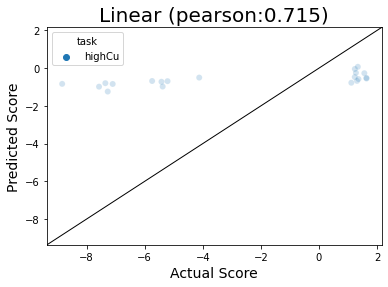

Running CNN


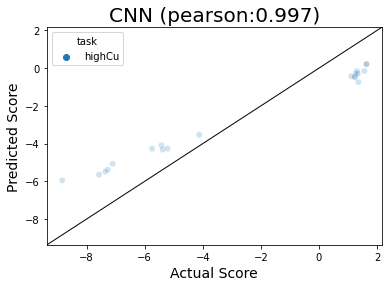

Running Kmer3


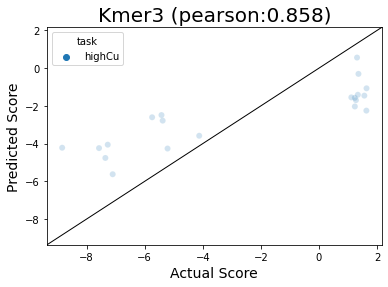

Running Kmer6


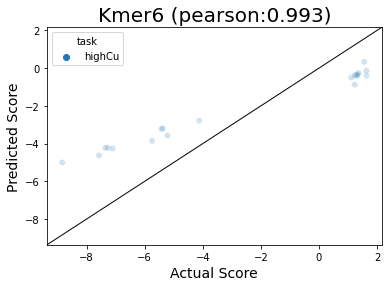

In [53]:
# models = [
#     ("LinearDeep_LR:NoCu",best_lin),
#     ("CNN_LR:NoCu",best_cnn),
#     ("Kmer3_LR:NoCu",best_kmer3),
#     ("Kmer6_LR:NoCu",best_kmer6),
# ]

models = [
    ("Linear",best_lin,DatasetSpec('ohe')),
    ("CNN",best_cnn,DatasetSpec('ohe')),
    ("Kmer3",best_kmer3,DatasetSpec('kmer',k=3)),
    ("Kmer6",best_kmer6,DatasetSpec('kmer',k=6)),
    #("CNN_8mer",mer8motif_model_cnn),
    
    #("CNN2_8mer",mer8motif_model_cnn2),
]

genes = XYdf_smol['locus_tag'].values
task = "opt_best_LR:NoCu"

dfs = parity_pred_multi(models, genes, oracle_nocu,task,['highCu'],alt=False)

In [70]:
def parity_pred(models, genes, oracle,task,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")
        
                
            actual = oracle[gene][0]
            pred = model(s.float())
            data.append([gene,actual,pred.item()])
        
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            tu.alt_parity_plot(model_name, df, pearson,task)
        tu.parity_plot(model_name, df, pearson)

    return dfs

Running Linear


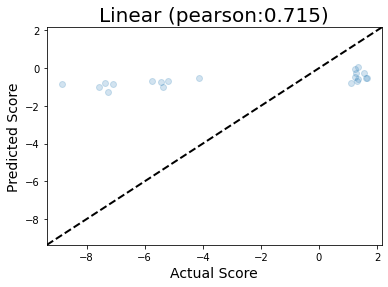

Running CNN


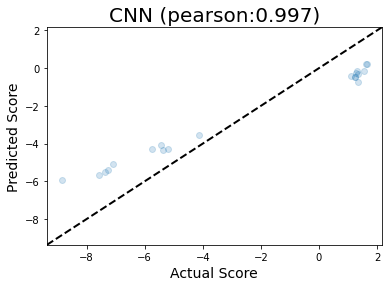

Running Kmer3


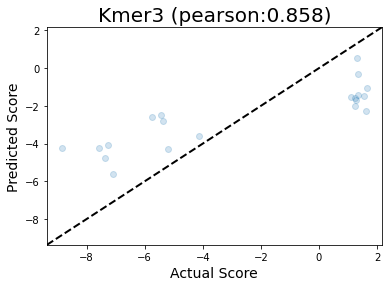

Running Kmer6


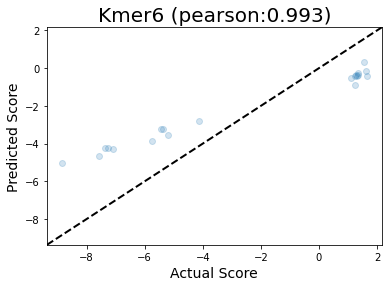

In [72]:
models = [
    ("Linear",best_lin,DatasetSpec('ohe')),
    ("CNN",best_cnn,DatasetSpec('ohe')),
    ("Kmer3",best_kmer3,DatasetSpec('kmer',k=3)),
    ("Kmer6",best_kmer6,DatasetSpec('kmer',k=6)),
    #("CNN_8mer",mer8motif_model_cnn),
    
    #("CNN2_8mer",mer8motif_model_cnn2),
]


#seqs = val_df['upstream_region'].values
genes = XYdf_smol['locus_tag'].values
task = "high:noCu"

dfs = parity_pred(models, genes, oracle_nocu,task,alt=False)

In [89]:
cnn_opt_study.best_params

{'conv0_filt_num': 64,
 'conv0_kernel_size': 8,
 'conv0_pool_size': 1,
 'conv0_dropout': 0.1,
 'n_hidden_conv': 0,
 'n_hidden_fc': 0}

In [91]:
XYdf_og.skew()

og_index                -0.019813
uMax                    -4.597662
lowO2_fast_growth       -3.717380
lowCH4                  -5.052518
MeOH                    -2.177226
NoCu                     0.000000
medCu                   -1.155126
highCu                  -5.785891
lowCu                    1.164351
highO2_slow_growth      -2.897980
NO3_lowO2_slow_growth    0.296438
WithLanthanum            0.120648
NoLanthanum              0.076901
dtype: float64

# Optuna viz functions

In [82]:
def opt_plots(study,skip_importances=False):
    display(optuna.visualization.plot_optimization_history(study))
    if not skip_importances:
        display(optuna.visualization.plot_param_importances(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))
    

In [84]:
opt_plots(lin_opt_study)

In [83]:
opt_plots(cnn_opt_study)

In [85]:
opt_plots(kmer3_opt_study)

In [86]:
opt_plots(kmer6_opt_study)